# Capstone Project-Machine Learning in Investment and Trading 
## Stock Price Predictor 
## full report 
https://github.com/parksoy/Udacity_nanoDegree_MachineLearning/blob/master/capstone/Project_report.pdf

Soyoung Park 

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%matplotlib inline 
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import urllib
import math
import datetime as dt
from datetime import datetime
from pandas import datetime
import scipy.optimize as spo
from scipy.spatial import distance
from sklearn.model_selection import TimeSeriesSplit
import datetime
import matplotlib.finance as finance
from IPython.display import display

os.getcwd()

'/Users/parksoy/Desktop/GoogleDrive_Soyoung/Udacity_nanoDegree_MachineLearning/capstone'


# 1. Data preprocessing
## 1-1. Download daily SPY(S&P 500) data, Intel adj close from Yahoo! Finance

In [3]:
#INPUT as global
symbol='INTC'
start_date = dt.datetime(1997,1,1)
end_date = dt.datetime(2017,3,9)



symbols = [symbol]
#download latest dataset with symbol from Yahoo Finance

def fetch_data(symbol,start_date,end_date):
    """ Downloads .csv files for <symbols> from Yahoo! Finance and saves them in './data' directory."""

    time_frame = "m" # d -> daily, w -> weekly, m -> monthly.
      
    start_date_mm=str(start_date.month-1)
    start_date_yyyy=str(start_date.year)
    start_date_dd=str(start_date.day)
    
    end_date_mm=str(end_date.month-1)
    end_date_yyyy=str(end_date.year)
    end_date_dd=str(end_date.day)

    url="http://real-chart.finance.yahoo.com/table.csv?s="+\
        symbol+\
        "&a="+start_date_mm+"&b="+start_date_dd+"&c="+start_date_yyyy+\
        "&d="+end_date_mm+"&e="+end_date_dd+"&f="+end_date_yyyy+\
        "&g="+time_frame+"+&ignore=.csv"

    csvfile,_=urllib.urlretrieve(url, './data/{}.csv'.format(symbol))
    print "Downloading for "+symbol
    print "URL:"+url
    statinfo = os.stat(csvfile)
    print 'File size:', statinfo.st_size/1000,"KB"

def run():
    #Download csv for symbols
    if "SPY" not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, "SPY")

    for symbol in symbols:
       fetch_data(symbol,start_date,end_date)
    
run()

URL:http://real-chart.finance.yahoo.com/table.csv?s=SPY&a=0&b=1&c=1997&d=2&e=9&f=2017&g=m+&ignore=.csv
File size: 362 KB
URL:http://real-chart.finance.yahoo.com/table.csv?s=INTC&a=0&b=1&c=1997&d=2&e=9&f=2017&g=m+&ignore=.csv
File size: 310 KB


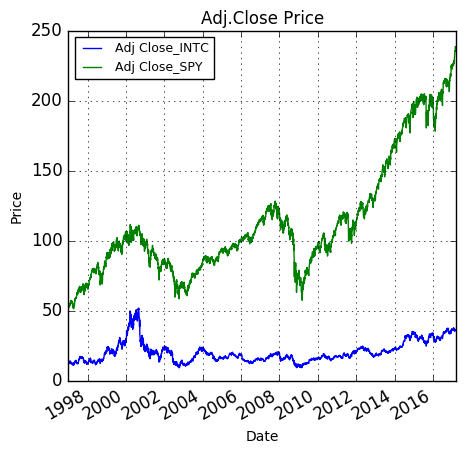

,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Adj Close_SPY,Open_INTC,High_INTC,Low_INTC,Close_INTC,Volume_INTC,Adj Close_INTC
1997-01-02,74.375,74.375,72.750000,74.031197,2031900.0,51.586402,131.75,132.0,127.625,130.375,97639200,11.206980
1997-01-03,74.375,75.125,74.078102,75.093697,2123200.0,52.326773,133.00,138.5,132.625,138.375,95648000,11.894656


5080


,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Adj Close_SPY,Open_INTC,High_INTC,Low_INTC,Close_INTC,Volume_INTC,Adj Close_INTC
2017-03-08,237.339996,237.639999,236.399994,236.559998,78168800.0,235.535317,35.669998,35.900002,35.529999,35.619999,20899400,35.619999
2017-03-09,236.699997,237.240005,235.740005,236.860001,90683900.0,235.834020,35.599998,35.939999,35.500000,35.820000,23543100,35.820000


In [4]:
def fill_missing_values(df_data):
    """Fill missing values in data frame, in place."""
    df_data.fillna(method="ffill", inplace=True)
    df_data.fillna(method="bfill", inplace=True)
    
def symbol_to_path(symbol, base_dir="data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(symbol))

def get_data(symbols, dates):
    
    """Read adjusted close only for given symbols from CSV files."""
    df_final = pd.DataFrame(index=dates)
    if "SPY" not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, "SPY")

    for symbol in symbols:
        file_path = symbol_to_path(symbol)
        df_temp = pd.read_csv(file_path,parse_dates=True,index_col="Date", na_values=["nan"]) #usecols=["Date", "Adj Close"],
        col_names=list(df_temp.columns)
        for col in col_names:
            col_symbol=col+"_"+symbol
            df_temp = df_temp.rename(columns={col: col_symbol})
        df_final = df_final.join(df_temp)
        df_final=df_final.dropna()
    return df_final

# Read data
plt.rcParams['figure.figsize'] = (5.0, 5.0)
dates = pd.date_range(start_date, end_date)
df_price = get_data(symbols, dates)
title="Adj.Close Price"; xlabel="Date"; ylabel="Price"
ax = df_price[['Adj Close_INTC','Adj Close_SPY']].plot(title=title, fontsize=12)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.grid(True)
ax.legend(loc="best", fontsize=9)
plt.show()

display(df_price[:2])
print len(df_price)
display(df_price[-2:])


In [5]:
df_price.describe()


,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Adj Close_SPY,Open_INTC,High_INTC,Low_INTC,Close_INTC,Volume_INTC,Adj Close_INTC
count,5080.000000,5080.000000,5080.000000,5080.000000,5.080000e+03,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5.080000e+03,5080.000000
mean,134.459123,135.307566,133.517644,134.455023,1.009243e+08,113.087162,38.657819,39.251511,38.069885,38.657588,5.576975e+07,20.471106
std,36.579981,36.570676,36.593608,36.598249,1.041148e+08,42.509442,31.808460,32.407136,31.228407,31.826342,2.873399e+07,7.588187
min,67.949997,70.000000,67.099998,68.110001,6.246000e+05,51.324953,12.170000,12.630000,12.050000,12.080000,1.155400e+06,9.191912
25%,110.540001,111.225724,109.680000,110.410004,1.931755e+07,84.717222,21.257500,21.480000,21.030001,21.240000,3.689150e+07,15.223982
50%,127.341847,128.132499,126.424999,127.365002,7.130120e+07,100.531442,25.969999,26.260000,25.690001,25.990000,5.195775e+07,18.537508
75%,146.645000,147.587502,145.626251,146.702499,1.472258e+08,123.601724,34.502499,34.849998,34.124999,34.540001,6.834310e+07,22.991063
max,239.559998,240.320007,238.369995,239.779999,8.710263e+08,238.741370,169.687500,169.750000,165.500000,169.312500,4.590144e+08,51.775121


# 2. BASELINE STUDY

### 2.1 Time series forecast for return

In [6]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from pandas.tools.plotting import autocorrelation_plot

#### 2.1.1 Forecasting the return with ARIMA model-Testing stationary, checking lag

In [7]:
#load the data
df_price = get_data(symbols, dates)
prices = df_price["Adj Close_INTC"]

#Return
df_price["Return_14day"]=prices/prices.shift(14)-1
df_price["log_Return_14day"]=np.log(df_price["Return_14day"])

#REMOVE NaN instead of filling with zero if want to incorporate log return. 
#df_price.fillna(0,inplace=True)
#index_NAN= df_merged["log_Return_14day"].index[df_merged["log_Return_14day"].apply(np.isinf)]
print df_price.shape
display(df_price[:2])
df_price=df_price.dropna(how="any",subset=["Return_14day","log_Return_14day"])
display(df_price[:2])


(5080, 14)


,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Adj Close_SPY,Open_INTC,High_INTC,Low_INTC,Close_INTC,Volume_INTC,Adj Close_INTC,Return_14day,log_Return_14day
1997-01-02,74.375,74.375,72.750000,74.031197,2031900.0,51.586402,131.75,132.0,127.625,130.375,97639200,11.206980,NaN,NaN
1997-01-03,74.375,75.125,74.078102,75.093697,2123200.0,52.326773,133.00,138.5,132.625,138.375,95648000,11.894656,NaN,NaN


,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Adj Close_SPY,Open_INTC,High_INTC,Low_INTC,Close_INTC,Volume_INTC,Adj Close_INTC,Return_14day,log_Return_14day
1997-01-22,78.3125,78.843697,77.875000,78.843697,1201600.0,54.939847,148.50,152.250,146.750,152.125,88490400,13.076601,0.166826,-1.790801
1997-01-23,79.0625,79.687500,76.906197,77.750000,2601100.0,54.177738,153.25,155.875,151.625,151.750,99123200,13.044366,0.096658,-2.336579


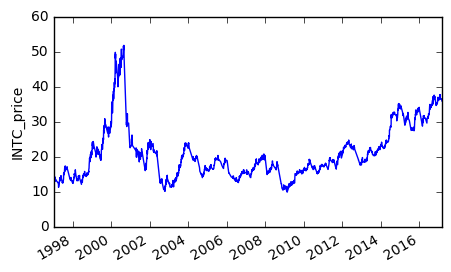

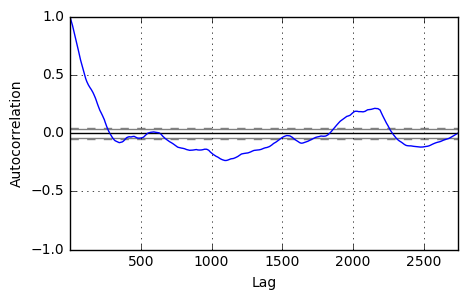

ADF Statistic: -2.290183
p-value: 0.175154
Critical Values:
	5%: -2.863
	1%: -3.433
	10%: -2.567


In [8]:
series=df_price['Adj Close_INTC']

plt.rcParams['figure.figsize'] = (5.0, 3.0)

# line plot
ax=series.plot()
ax.set_ylabel('INTC_price')
plt.show()

# autocorrelation plot
autocorrelation_plot(series)
plt.show()

# statistical test #The null hypothesis of the test is that the time series is non-stationary.
result = adfuller(series) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

Test statistic value was -2.290183. This is larger than all of the critical values at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series appears to be **"non-stationary"** with a low likelihood of the result being a statistical fluke.

#### 2.1.2 Make indicator as stationary by taking return

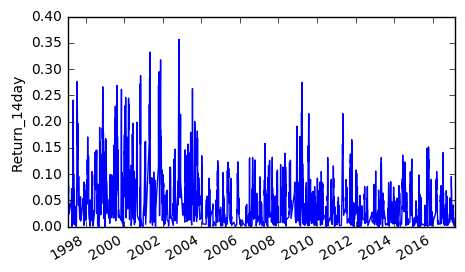

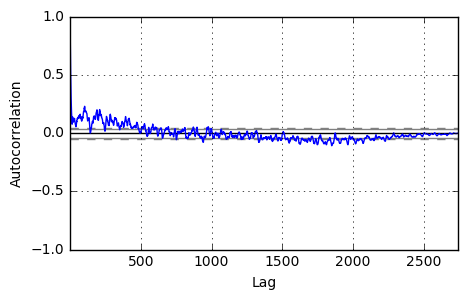

ADF Statistic: -7.783218
p-value: 0.000000
Critical Values:
	5%: -2.863
	1%: -3.433
	10%: -2.567


In [9]:
series=df_price["Return_14day"]

plt.rcParams['figure.figsize'] = (5.0, 3.0)

# line plot
ax=series.plot()
ax.set_ylabel('Return_14day')
plt.show()

# autocorrelation plot
autocorrelation_plot(series)
plt.show()

# statistical test #The null hypothesis of the test is that the time series is non-stationary.
result = adfuller(series) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

** 14-day return is now stationary. **

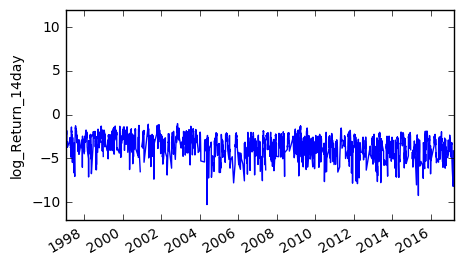

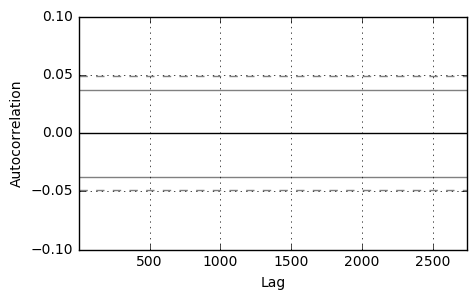

"\n# statistical test #The null hypothesis of the test is that the time series is non-stationary.\nresult = adfuller(series) \nprint('ADF Statistic: %f' % result[0])\nprint('p-value: %f' % result[1])\nprint('Critical Values:')\nfor key, value in result[4].items():\n    print('\t%s: %.3f' % (key, value))\n"

In [10]:
series=df_price["log_Return_14day"]

plt.rcParams['figure.figsize'] = (5.0, 3.0)

# line plot
ax=series.plot()
ax.set_ylabel('log_Return_14day')
ax.set_ylim(-12,12)
plt.show()

# autocorrelation plot
ax2=autocorrelation_plot(series)
ax2.set_ylim(-0.1,0.1)
plt.show()

'''
# statistical test #The null hypothesis of the test is that the time series is non-stationary.
result = adfuller(series) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
'''

#### 2.1.3. residual after a simple model

In [11]:
#Forcasting the return with ARIMA model

#DROP any inf - fillingNA with zero causes large error in price backcalculation. Need to remove inf.
index_INF= df_price["log_Return_14day"].index[df_price["log_Return_14day"].apply(np.isinf)]
print index_INF.strftime("%Y-%m-%d")


['1997-04-11' '1998-09-11' '1998-12-30' '1999-12-16' '2000-10-24'
 '2000-12-22' '2005-04-07' '2006-07-28' '2007-06-13' '2010-11-30'
 '2012-03-01' '2014-12-23' '2015-09-29']


In [12]:
display(df_price['1997-04-10':'1997-04-12'])#'2012-02-22':'2012-03-01'
df_price=df_price.drop(index_INF)
display(df_price['1997-04-10':'1997-04-12'])

,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Adj Close_SPY,Open_INTC,High_INTC,Low_INTC,Close_INTC,Volume_INTC,Adj Close_INTC,Return_14day,log_Return_14day
1997-04-10,76.093697,76.546799,75.6875,75.781197,1996500.0,53.008059,142.75,142.75,137.015594,137.25,123181600,11.801860,0.030019,-3.505933
1997-04-11,75.062500,75.312500,73.3750,73.375000,4221600.0,51.324953,135.25,135.25,129.750000,130.50,192564000,11.221441,0.000000,-inf


,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Adj Close_SPY,Open_INTC,High_INTC,Low_INTC,Close_INTC,Volume_INTC,Adj Close_INTC,Return_14day,log_Return_14day
1997-04-10,76.093697,76.546799,75.6875,75.781197,1996500.0,53.008059,142.75,142.75,137.015594,137.25,123181600,11.80186,0.030019,-3.505933


In [13]:
#Forcasting the return with ARIMA model

y = df_price["log_Return_14day"]

tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(y):
    y_train, y_test = y[:len(train_index)], y[len(train_index):(len(train_index)+len(test_index))]
    
print "y_train, y_test",y_train.shape,y_test.shape

#size = int(len(X) * 0.66)
#train, test = X[0:size], X[size:len(X)]

history = [y for y in y_train]
predictions = []

for t in range(len(y_test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    observ = y_test[t]
    history.append(observ)

# evaluate forecasts
RMSE = sqrt(mean_squared_error(y_test, predictions))
print "RMSE==",RMSE

#Rsqr=model_fit.score(predictions,history)
#print "R^2 ==",Rsqr

y_train, y_test (2046,) (681,)
RMSE== 0.85663436811


In [14]:
#Log to dictionary to compare with other models
all_regressor_RMSE={}
all_regressor_RMSE.update({"ARIMA": RMSE})
print all_regressor_RMSE

{'ARIMA': 0.8566343681103521}


,pred_y,test_y
2012-04-16,-4.590198,-4.853097
2012-04-17,-4.865438,-4.611938


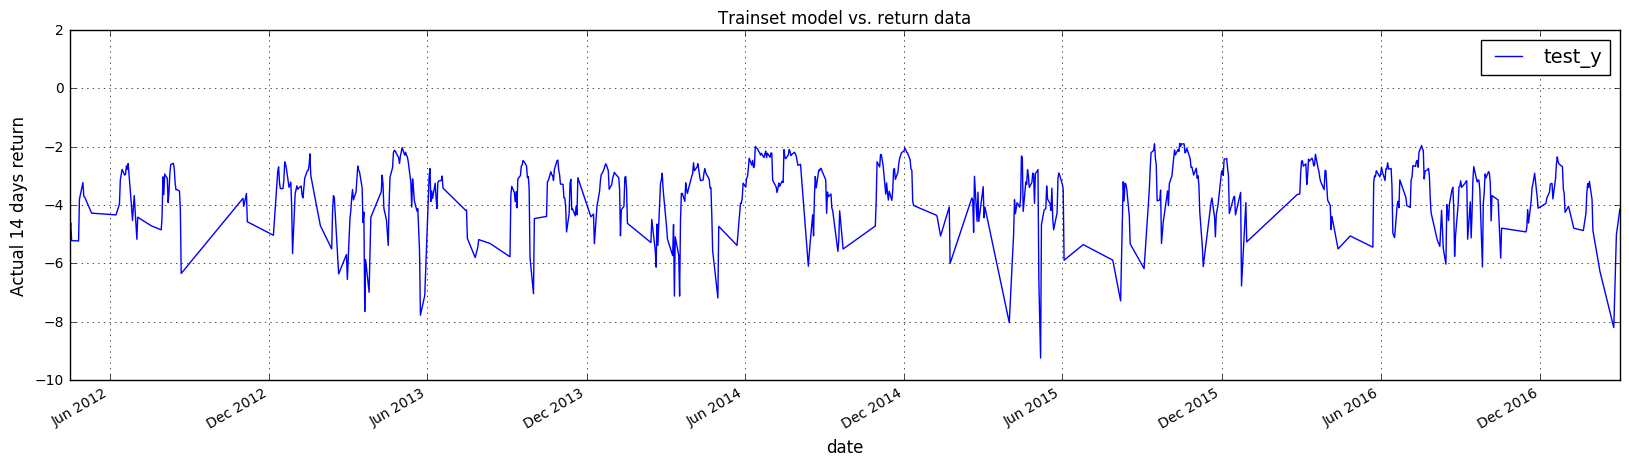

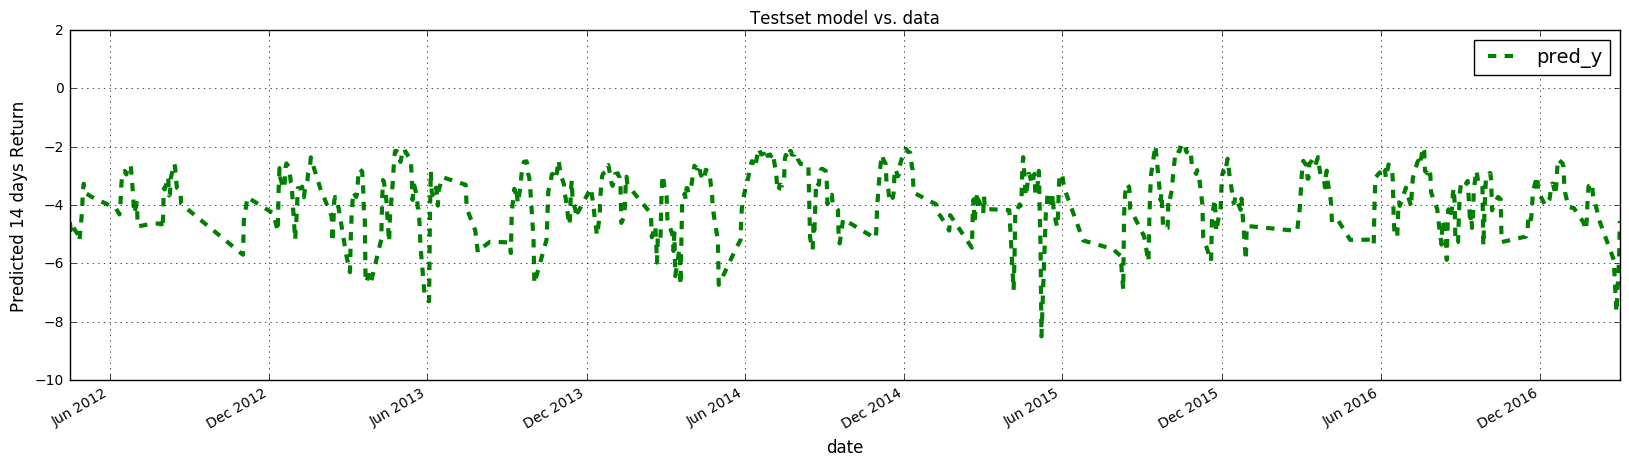

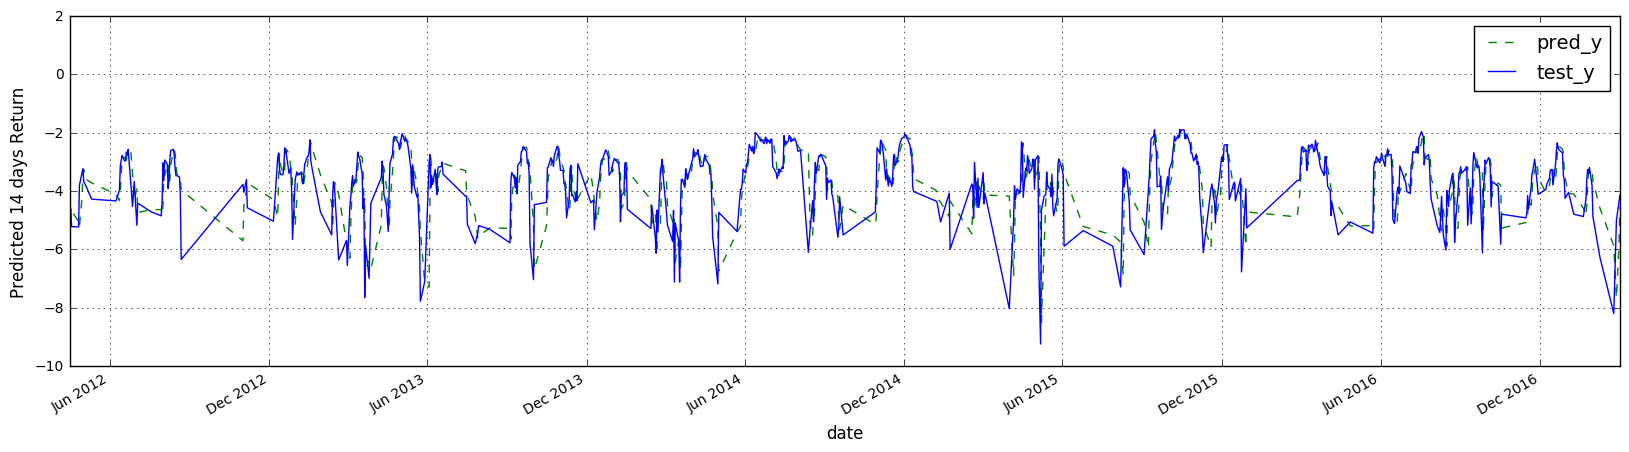

In [15]:
#Deal with dataframe and plot pred vs. test data
plt.rcParams['figure.figsize'] = (20.0, 5.0)

test_y = pd.DataFrame({'test_y':y_test}, index=y_test.index)
prediction_y=pd.Series( (v[0] for v in predictions))
prediction_y_df=pd.DataFrame({'pred_y':[v[0] for v in predictions]},  index=y_test.index)
test_pred_y=prediction_y_df.join(test_y)
display(test_pred_y[:2])

#Plot return data vs. prediction

ax1=test_pred_y['test_y'].plot()
ax1.set_xlabel('date',fontsize=12)
ax1.set_ylabel("Actual 14 days return",fontsize=12)
ax1.set_ylim([-10,2])
ax1.set_title('Trainset model vs. return data')
ax1.grid(True)
ax1.legend(loc="best", fontsize=14)
plt.show()

#Check testset data vs. prediction
ax2=test_pred_y['pred_y'].plot(style=['g--'],lw=3) #color='green',
ax2.set_xlabel('date',fontsize=12)
ax2.set_ylabel("Predicted 14 days Return",fontsize=12)
ax2.set_ylim([-10,2])
ax2.set_title('Testset model vs. data')
ax2.grid(True)
ax2.legend(loc="best", fontsize=14)
plt.show()

#Check testset data vs. prediction
ax3=test_pred_y.plot(style=['g--','b'])
ax3.set_xlabel('date',fontsize=12)
ax3.set_ylabel("Predicted 14 days Return",fontsize=12)
ax3.set_ylim([-10,2])
ax2.set_title('Testset model vs. data')
ax3.grid(True)
ax3.legend(loc="best", fontsize=14)
plt.show()

,pred_today_price,calc_today_price,Adj Close_INTC,Error_pred_actual
2017-02-08,36.683127,36.380001,36.380001,0.833220
2017-02-24,36.621900,36.529999,36.529999,0.251578
2017-02-27,36.286847,36.509998,36.509998,-0.611204
2017-03-02,35.557234,35.910000,35.910000,-0.982360
2017-03-03,35.714752,35.900002,35.900002,-0.516016


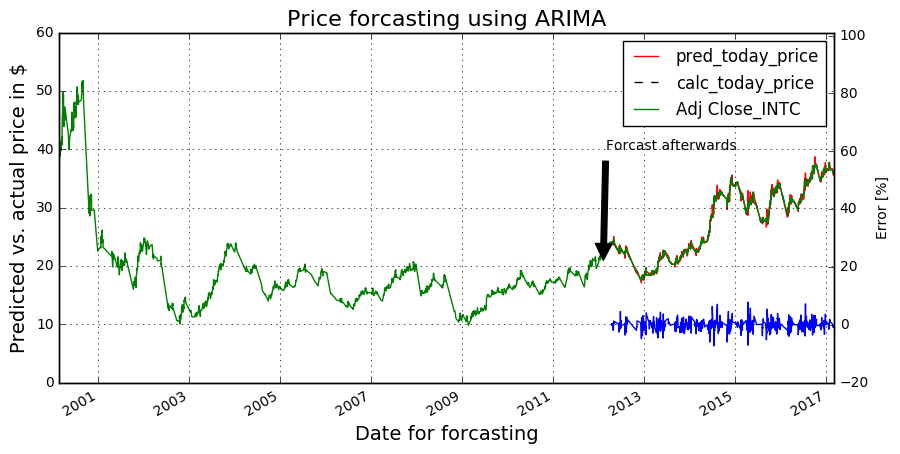

In [16]:
#convert to price to compute accuracy of actual price prediction for this ARIMA model

#actual price
df_price["calc_return_14days"]=np.exp(test_pred_y['test_y'])
df_price["calc_today_price"]=(df_price["calc_return_14days"]+1)*prices.shift(14)
df_price['Error_pred_actual']=(df_price["calc_today_price"]-df_price["Adj Close_INTC"])/df_price["Adj Close_INTC"]*100

#predicted price
df_price["pred_return_14days"]=np.exp(test_pred_y['pred_y'])
df_price["pred_today_price"]=(df_price["pred_return_14days"]+1)*prices.shift(14)
df_price['Error_pred_actual']=(df_price["pred_today_price"]-df_price["Adj Close_INTC"])/df_price["Adj Close_INTC"]*100


#check if done correctly
display(df_price[["pred_today_price","calc_today_price","Adj Close_INTC","Error_pred_actual"]].loc['2012-02-22':][-5:]) #'2012-02-28'
fig=plt.figure()

plt.rcParams['figure.figsize'] = (10.0, 5.0)

ax1=df_price[["pred_today_price","calc_today_price","Adj Close_INTC","Error_pred_actual"]].plot(style=['r-','k--','g','b'],
                                                                  secondary_y=['Error_pred_actual']) #  lw=3, legend=['a','b'],
ax1.set_xlim('2000-02-22','2017-03-09')
ax1.set_xlabel('Date for forcasting',fontsize=14)
ax1.set_ylabel('Predicted vs. actual price in $',fontsize=14)
ax1.right_ax.set_ylabel('Error [%]')
ax1.right_ax.set_ylim(-20,101)
ax1.annotate('Forcast afterwards', xy=('2012-02-08', 20), xytext=('2012-02-29', 40),
            arrowprops=dict(facecolor='black', shrink=0.05), 
            ) #
ax1.grid('on')
ax1.set_title("Price forcasting using ARIMA",fontsize=16)
ax1.legend(loc='best')

In [17]:
#Another error metric between predicted price and actual price 

print df_price['Error_pred_actual'].mean()


-0.0844136999959


## 3. Further Data preprocessing To Add more features/targets for regression and classification

## 3-1. Adding more targets based on adj. close price

In [18]:
#Adding more targets
df_price = get_data(symbols, dates)
prices = df_price["Adj Close_INTC"]

#Return
df_price["Return_1day"]=(prices/prices.shift(1))-1
df_price["Return_7day"]=(prices/prices.shift(7))-1
df_price["Return_14day"]=(prices/prices.shift(14))-1
df_price["Return_28day"]=(prices/prices.shift(28))-1
#df_price["Return_120day"]=(prices/prices.shift(120))-1
#df_price["Return_365day"]=(prices/prices.shift(365))-1

df_price["log_Return_1day"]=np.log(df_price["Return_1day"])
df_price["log_Return_7day"]=np.log(df_price["Return_7day"])
df_price["log_Return_14day"]=np.log(df_price["Return_14day"])
df_price["log_Return_28day"]=np.log(df_price["Return_28day"])
#df_price["log_Return_120day"]=np.log(df_price["Return_120day"])
#df_price["log_Return_365day"]=np.log(df_price["Return_365day"])

df_price.fillna(method="ffill", inplace=True)
df_price.fillna(method="bfill", inplace=True)
#df_price=df_price.interpolate(method='linear')#fillna(0)

display(df_price[:8])
print df_price.shape

,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Adj Close_SPY,Open_INTC,High_INTC,Low_INTC,Close_INTC,Volume_INTC,Adj Close_INTC,Return_1day,Return_7day,Return_14day,Return_28day,log_Return_1day,log_Return_7day,log_Return_14day,log_Return_28day
1997-01-02,74.375000,74.375000,72.750000,74.031197,2031900.0,51.586402,131.7500,132.000000,127.625000,130.375,97639200,11.206980,0.061361,0.126558,0.166826,0.164336,-2.790974,-2.067055,-1.790801,-1.805844
1997-01-03,74.375000,75.125000,74.078102,75.093697,2123200.0,52.326773,133.0000,138.500000,132.625000,138.375,95648000,11.894656,0.061361,0.126558,0.166826,0.164336,-2.790974,-2.067055,-1.790801,-1.805844
1997-01-06,75.093697,75.437500,74.312500,74.437500,1374100.0,51.869523,139.1250,141.750000,137.750000,138.875,120549600,11.937636,0.003613,0.126558,0.166826,0.164336,-5.623110,-2.067055,-1.790801,-1.805844
1997-01-07,74.437500,75.468697,74.125000,75.343697,939000.0,52.500978,138.5625,143.500000,137.000000,143.375,96153600,12.324454,0.032403,0.126558,0.166826,0.164336,-3.429497,-2.067055,-1.790801,-1.805844
1997-01-08,75.750000,75.781197,74.687500,74.687500,1802200.0,52.043727,144.0000,145.625000,141.765594,142.250,125510400,12.227750,-0.007847,0.126558,0.166826,0.164336,-3.429497,-2.067055,-1.790801,-1.805844
1997-01-09,75.062500,75.875000,74.937500,75.312500,1415700.0,52.479240,143.3750,144.000000,141.750000,143.000,77420000,12.292219,0.005272,0.126558,0.166826,0.164336,-5.245279,-2.067055,-1.790801,-1.805844
1997-01-10,74.250000,76.250000,74.250000,76.125000,2369500.0,53.045406,142.1250,144.750000,141.500000,144.500,111907200,12.421159,0.010490,0.126558,0.166826,0.164336,-4.557375,-2.067055,-1.790801,-1.805844
1997-01-13,76.500000,76.500000,75.640602,76.015602,1364600.0,52.969175,145.7500,147.765594,144.000000,146.875,116600000,12.625313,0.016436,0.126558,0.166826,0.164336,-4.108282,-2.067055,-1.790801,-1.805844


(5080, 20)


In [19]:
#Remove any INF
index_INF= df_price["log_Return_7day"].index[df_price["log_Return_7day"].apply(np.isinf)]
print index_INF.strftime("%Y-%m-%d")
df_price=df_price.drop(index_INF)
index_INF= df_price["log_Return_14day"].index[df_price["log_Return_14day"].apply(np.isinf)]
print index_INF.strftime("%Y-%m-%d")
df_price=df_price.drop(index_INF)
index_INF= df_price["log_Return_28day"].index[df_price["log_Return_28day"].apply(np.isinf)]
print index_INF.strftime("%Y-%m-%d")
df_price=df_price.drop(index_INF)

['1997-03-04' '1998-06-16' '1998-06-17' '1998-06-18' '1998-07-22'
 '2001-08-31' '2001-09-04' '2001-09-05' '2001-09-06' '2001-09-07'
 '2001-09-10' '2001-09-17' '2001-09-18' '2001-09-19' '2001-09-20'
 '2001-09-21' '2001-09-24' '2001-09-25' '2001-09-26' '2001-09-27'
 '2001-09-28' '2001-10-01' '2002-11-19' '2005-09-29' '2007-02-15'
 '2007-02-16' '2007-02-20' '2007-02-21' '2008-08-28' '2008-08-29'
 '2008-09-02' '2008-09-03' '2008-09-04' '2008-09-05' '2008-09-08'
 '2008-09-09' '2008-09-10' '2008-09-11' '2008-09-12' '2008-09-15'
 '2008-09-16' '2008-09-17' '2008-09-18' '2008-09-19' '2008-09-22'
 '2008-09-23' '2008-09-24' '2008-09-25' '2009-02-13' '2009-02-17'
 '2009-02-18' '2009-02-19' '2009-02-20' '2009-02-23' '2009-02-24'
 '2009-02-25' '2009-02-26' '2009-02-27' '2009-03-02' '2009-03-03'
 '2009-04-24' '2009-04-27' '2009-04-28' '2010-01-15' '2010-02-02'
 '2010-02-03' '2010-02-04' '2010-02-05' '2010-02-08' '2010-03-26'
 '2011-02-14' '2011-02-15' '2011-08-16' '2012-07-25' '2013-07-29'
 '2014-02-

In [20]:
display(df_price[:8])
print df_price.shape

,Open_SPY,High_SPY,Low_SPY,Close_SPY,Volume_SPY,Adj Close_SPY,Open_INTC,High_INTC,Low_INTC,Close_INTC,Volume_INTC,Adj Close_INTC,Return_1day,Return_7day,Return_14day,Return_28day,log_Return_1day,log_Return_7day,log_Return_14day,log_Return_28day
1997-01-02,74.375000,74.375000,72.750000,74.031197,2031900.0,51.586402,131.7500,132.000000,127.625000,130.375,97639200,11.206980,0.061361,0.126558,0.166826,0.164336,-2.790974,-2.067055,-1.790801,-1.805844
1997-01-03,74.375000,75.125000,74.078102,75.093697,2123200.0,52.326773,133.0000,138.500000,132.625000,138.375,95648000,11.894656,0.061361,0.126558,0.166826,0.164336,-2.790974,-2.067055,-1.790801,-1.805844
1997-01-06,75.093697,75.437500,74.312500,74.437500,1374100.0,51.869523,139.1250,141.750000,137.750000,138.875,120549600,11.937636,0.003613,0.126558,0.166826,0.164336,-5.623110,-2.067055,-1.790801,-1.805844
1997-01-07,74.437500,75.468697,74.125000,75.343697,939000.0,52.500978,138.5625,143.500000,137.000000,143.375,96153600,12.324454,0.032403,0.126558,0.166826,0.164336,-3.429497,-2.067055,-1.790801,-1.805844
1997-01-08,75.750000,75.781197,74.687500,74.687500,1802200.0,52.043727,144.0000,145.625000,141.765594,142.250,125510400,12.227750,-0.007847,0.126558,0.166826,0.164336,-3.429497,-2.067055,-1.790801,-1.805844
1997-01-09,75.062500,75.875000,74.937500,75.312500,1415700.0,52.479240,143.3750,144.000000,141.750000,143.000,77420000,12.292219,0.005272,0.126558,0.166826,0.164336,-5.245279,-2.067055,-1.790801,-1.805844
1997-01-10,74.250000,76.250000,74.250000,76.125000,2369500.0,53.045406,142.1250,144.750000,141.500000,144.500,111907200,12.421159,0.010490,0.126558,0.166826,0.164336,-4.557375,-2.067055,-1.790801,-1.805844
1997-01-13,76.500000,76.500000,75.640602,76.015602,1364600.0,52.969175,145.7500,147.765594,144.000000,146.875,116600000,12.625313,0.016436,0.126558,0.166826,0.164336,-4.108282,-2.067055,-1.790801,-1.805844


(4929, 20)


## 3-2. Adding more features based on adj. close price

In [21]:
#utils-the majority of this code is refered from ML4Trading course offered by Udacity. 

def normarlize_data(df):
    return df/df.ix[0,:]

def plot_data(df_data,title="Stock Data",xlabel="Date",ylabel="Price"):
    """Plot stock data with appropriate axis labels."""
    ax = df_data.plot(title=title, fontsize=7)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend(loc="best", fontsize=4)
    plt.show()

def plot_selected(df, columns, start_index, end_index):
    """Plot the desired columns over index values in the given range."""
    df_plot=df.ix[end_index:start_index,columns]
    df_plot=normarlize_data(df_plot)
    plot_data(df_plot, title='Selected Stock Prices')

def plot_normalized_data(df, title, xlabel, ylabel):
    #Normalize given stock prices and plot for comparison.
    #This is used to create a chart that illustrates the value of your portfolio over the year and compares it to SPY.
    #Note: Before plotting, portfolio and SPY values should be normalized to 1.0 at the beginning of the period.
    #Also, use the plot_data() utility function to generate and show your plot.
    df=normarlize_data(df)
    plot_data(df, title=title, ylabel="Normalized value")

#indicators

def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    upper_band=rm+2*rstd
    lower_band=rm-2*rstd
    return upper_band, lower_band


#http://matplotlib.org/examples/pylab_examples/finance_work2.html
def moving_average(x, n, type='simple'):
    """compute an n period moving average.type is 'simple' | 'exponential'"""
    x_np = np.asarray(x)
    if type == 'simple': weights = np.ones(n)
    else: weights = np.exp(np.linspace(-1., 0., n))
    weights /= weights.sum()
    a = np.convolve(x_np, weights, mode='full')[:len(x_np)]
    a[:n] = a[n]
    a=pd.Series(a, index=x.index, name=type+" Moving Average")
    return a

def relative_strength(prices, n=14):
    """compute the n period relative strength indicator"""
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1. + rs)
    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up*(n - 1) + upval)/n
        down = (down*(n - 1) + downval)/n
        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)
        rsi=pd.Series(rsi,index=prices.index,name="RSI")
    return rsi

def moving_average_convergence(x, nslow=26, nfast=12):
    """ compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    emaslow=pd.Series(emaslow, index=x.index, name="emaslow")
    emafast=pd.Series(emafast, index=x.index, name="emafast")
    return emaslow, emafast, emafast - emaslow


In [22]:
#technical indicators based on adj. close price

#Bollinger band 
window=20
rm=prices.rolling(window=window).mean()
rstd=prices.rolling(window=window).std()
upper_band, lower_band=get_bollinger_bands(rm, rstd)
 
#RSI
rsi = relative_strength(prices)

#SMA
ma20 = moving_average(prices, 20, type='simple')
ma200 = moving_average(prices, 200, type='simple')
ma50 = moving_average(prices, 50, type='simple')

#MACD
nslow = 26; nfast = 12; nema = 9
emaslow, emafast, macd = moving_average_convergence(prices, nslow=nslow, nfast=nfast)

print "prices",type(prices),"\nrm",type(rm),"\nrstd",type(rstd),"\nupperband",type(upper_band),"\nlowerband",type(lower_band),"\nrsi",type(rsi)
print "\nma20",type(ma20),"\nemaslow",type(emaslow),"\nemafast",type(emafast),"\nmacd",type(macd)


prices <class 'pandas.core.series.Series'> 
rm <class 'pandas.core.series.Series'> 
rstd <class 'pandas.core.series.Series'> 
upperband <class 'pandas.core.series.Series'> 
lowerband <class 'pandas.core.series.Series'> 
rsi <class 'pandas.core.series.Series'>

ma20 <class 'pandas.core.series.Series'> 
emaslow <class 'pandas.core.series.Series'> 
emafast <class 'pandas.core.series.Series'> 
macd <class 'pandas.core.series.Series'>


In [23]:
df_features=pd.DataFrame({"SPY_price":df_price["Adj Close_SPY"],
                          "Rolling_mean":rm,
                          "Rolling_std":rstd,
                          "Bollinger_upperband":upper_band,
                          "Bollinger_lowerband":lower_band,
                          "RSI":rsi,
                          "SMA20":ma20,
                          "SMA50":ma50,
                          "SMA200":ma200,
                          "EMA_slow":emaslow,
                          "EMA_fast":emafast,
                          "MACD":macd
                         }, index=prices.index)

fill_missing_values(df_features)
display(df_features[:10])

,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
1997-01-02,11.506095,13.480646,12.261038,12.709446,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,51.586402
1997-01-03,11.506095,13.480646,12.261038,12.709446,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,52.326773
1997-01-06,11.506095,13.480646,12.261038,12.709446,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,51.869523
1997-01-07,11.506095,13.480646,12.261038,12.709446,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,52.500978
1997-01-08,11.506095,13.480646,12.261038,12.709446,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,52.043727
1997-01-09,11.506095,13.480646,12.261038,12.709446,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,52.479240
1997-01-10,11.506095,13.480646,12.261038,12.709446,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,53.045406
1997-01-13,11.506095,13.480646,12.261038,12.709446,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,52.969175
1997-01-14,11.506095,13.480646,12.261038,12.709446,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,53.633310
1997-01-15,11.506095,13.480646,12.261038,12.709446,-0.448408,80.86643,12.49337,0.493638,12.621463,13.830099,12.789418,53.502657


In [24]:
df_merged=df_features.join(df_price, how='inner')
print df_merged.shape,"\n",df_merged.columns.values

(4929, 32) 
['Bollinger_lowerband' 'Bollinger_upperband' 'EMA_fast' 'EMA_slow' 'MACD'
 'RSI' 'Rolling_mean' 'Rolling_std' 'SMA20' 'SMA200' 'SMA50' 'SPY_price'
 'Open_SPY' 'High_SPY' 'Low_SPY' 'Close_SPY' 'Volume_SPY' 'Adj Close_SPY'
 'Open_INTC' 'High_INTC' 'Low_INTC' 'Close_INTC' 'Volume_INTC'
 'Adj Close_INTC' 'Return_1day' 'Return_7day' 'Return_14day' 'Return_28day'
 'log_Return_1day' 'log_Return_7day' 'log_Return_14day' 'log_Return_28day']


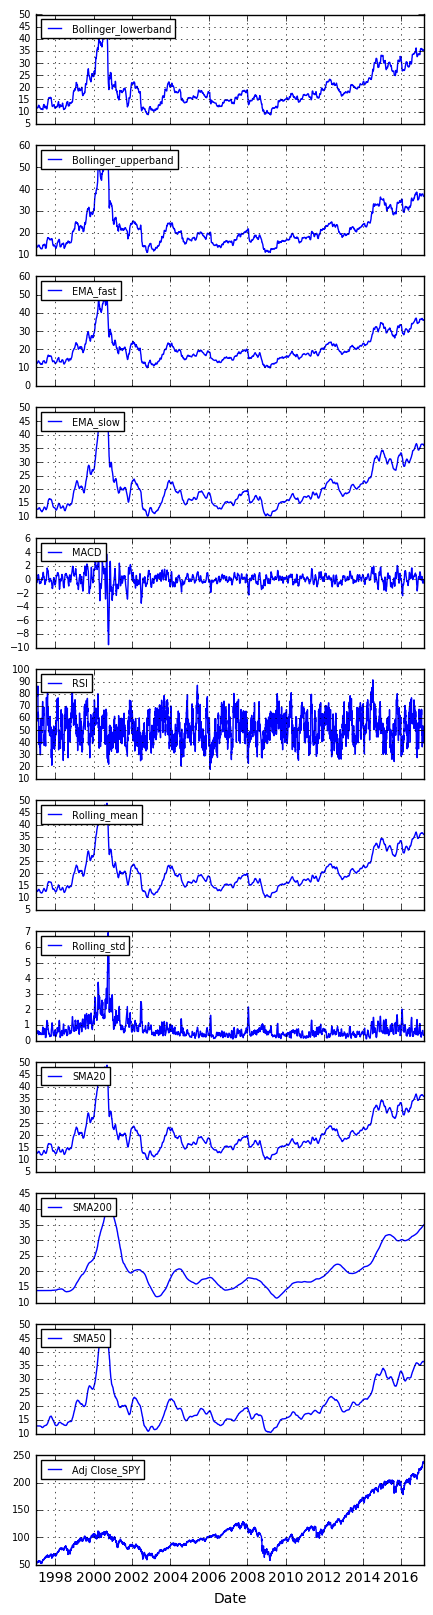

In [25]:
list(df_merged.columns)
plotcol_feat=[
 'Bollinger_lowerband',
 'Bollinger_upperband',
 'EMA_fast',
 'EMA_slow',
 'MACD',
 'RSI',
 'Rolling_mean',
 'Rolling_std',
 'SMA20',
 'SMA200',
 'SMA50',
    'Adj Close_SPY']

plotcol_targ=[

 'Adj Close_INTC',
 'Return_1day',
 'Return_7day',
 'Return_14day',
 'Return_28day',
 'log_Return_1day',
 'log_Return_7day',
 'log_Return_14day',
 'log_Return_28day',
 ]

plt.rcParams['figure.figsize'] = (5.0, 20.0)
f, ax = plt.subplots(nrows=len(plotcol_feat),sharex=True) #

for i,colname in enumerate(plotcol_feat):
    ax[i].plot(df_merged[colname])
    ax[i].set_ylabel("")
    ax[i].grid(True)
    ax[i].legend(loc='upper left',fontsize=7)
    ax[i].tick_params(axis='y', which='major', labelsize=7)
ax[i].set_xlabel('Date')
plt.show()
f.savefig('feat.png')

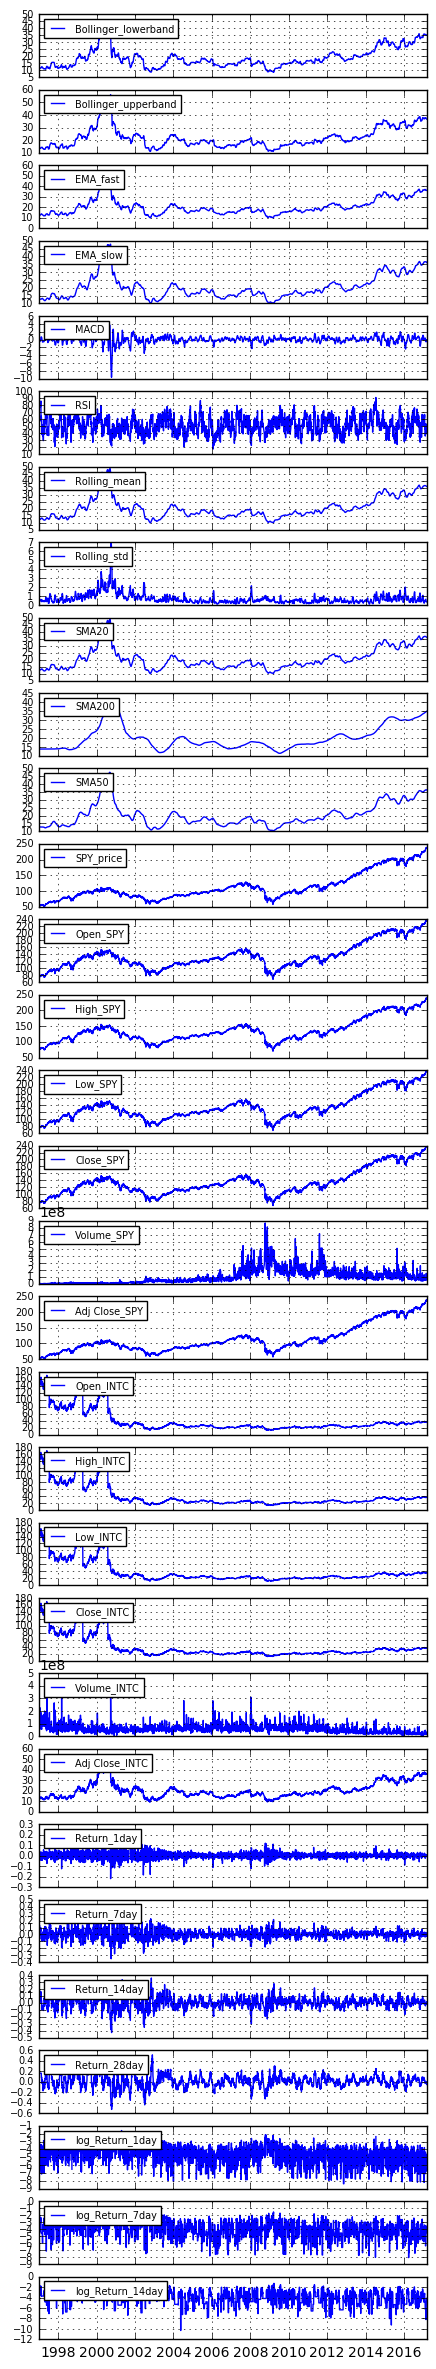

In [26]:
plt.rcParams['figure.figsize'] = (5.0, 30.0)
f, ax = plt.subplots(nrows=len(df_merged.columns[:-1]),sharex=True) #

for i,colname in enumerate(df_merged.columns[:-1]):
    ax[i].plot(df_merged[colname])
    ax[i].set_ylabel("")
    ax[i].grid(True)
    ax[i].legend(loc='upper left',fontsize=7)
    ax[i].tick_params(axis='y', which='major', labelsize=7)
plt.show()

In [27]:
#Split target(y) and features(X) 

y = df_merged['Adj Close_INTC']
X = pd.DataFrame([  
                    df_merged['Bollinger_lowerband'], 
                    df_merged['Bollinger_upperband'], 
                    df_merged['EMA_fast'],
                    df_merged['EMA_slow'],
                    df_merged['MACD'], 
                    df_merged['RSI'], 
                    df_merged['Rolling_mean'],
                    df_merged['Rolling_std'], 
                    df_merged['SMA20'], 
                    df_merged['SMA200'], 
                    df_merged['SMA50'], 
                    df_merged['SPY_price']
        
                 ]).transpose()


#Scale all features based on z-score 
from scipy.stats import zscore

X_z=X.apply(zscore)
display(X_z[-3:])


,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
2017-03-07,2.332618,1.818230,2.083260,2.109330,-0.070876,-0.685624,2.075810,-0.603357,2.075891,2.196044,2.165055,2.889531
2017-03-08,2.325526,1.815384,2.074349,2.099694,-0.065769,-0.898257,2.070957,-0.592473,2.071038,2.200616,2.162220,2.879229
2017-03-09,2.323477,1.810296,2.065105,2.095279,-0.104219,-0.580089,2.067235,-0.603720,2.067316,2.205278,2.159817,2.886253


In [28]:
#split trainset and testset.
print X_z.shape, y.shape
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(X):
    y_train, y_test = y[train_index], y[test_index]
    X_train, X_test = X_z.iloc[train_index], X_z.iloc[test_index]

print "X_train, y_train,X_test, y_test",X_train.shape, y_train.shape,X_test.shape, y_test.shape

display(X_train[:1])
display(X_train[-1:])
display(y_train[:1])
display(X_test[:1])
display(X_test[-1:])
display(y_test[:1])

print type(y_train) 

(4929, 12) (4929,)
X_train, y_train,X_test, y_test (3697, 12) (3697,) (1232, 12) (1232,)


,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
1997-01-02,-1.06866,-1.029376,-1.086625,-1.028888,-0.522295,2.401139,-1.057851,-0.386246,-1.040967,-0.930978,-1.02576,-1.446264


,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
2012-02-24,0.452131,0.142268,0.298444,0.276207,0.193461,0.28704,0.288011,-0.826124,0.287962,-0.102331,0.168373,0.232991


1997-01-02    11.20698
Name: Adj Close_INTC, dtype: float64

,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
2012-02-27,0.454381,0.144192,0.29835,0.285048,0.123408,0.535739,0.290105,-0.82613,0.290057,-0.099746,0.176434,0.237849


,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
2017-03-09,2.323477,1.810296,2.065105,2.095279,-0.104219,-0.580089,2.067235,-0.60372,2.067316,2.205278,2.159817,2.886253


2012-02-27    22.782848
Name: Adj Close_INTC, dtype: float64

<class 'pandas.core.series.Series'>


In [29]:
print "test_start=",X_test.index[0], "test_end=",X_test.index[-1]

test_start= 2012-02-27 00:00:00 test_end= 2017-03-09 00:00:00


# 4. Fit and predict

## 4.1 Regression of PRICE!

In [30]:
#Made a function to train, predict, and plot data vs. prediction

regressor_RMSE={}

def train_predict_evaluate(regressor,X_train, y_train,X_test):
    regressor.fit(X_train, y_train)
    y_train_pred=regressor.predict(X_train)
    y_test_pred=regressor.predict(X_test)
   
    #Evaluation of regression
    print "\n****Evaluation of regression in testset****"
    Rsqr=regressor.score(X_test,y_test)
    RMSE=np.sqrt((np.sum((y_test_pred-y_test)**2))/len(y_test_pred))

    #R square=(1 - u/v), where u is the regression sum of squares ((y_true - y_pred) ** 2).sum() 
    #and v is the residual sum of squares ((y_true - y_true.mean()) ** 2).sum()
    #R^2=coefficient of determination of the prediction in test set
    print "R^2 ==",Rsqr
    print "RMSE==",RMSE
    regressor_RMSE.update({regressor.__class__.__name__: RMSE})


    ##convert np array to df to plot together 
    df_train_pred = pd.DataFrame({'y_train_pred':y_train_pred}, index=y_train.index)
    df_train_pred.head(2)

    df_merged_trainPred=y_train.to_frame('INTC_price').join(df_train_pred)
    df_merged_trainPred.head(2)

    #Plot 
    plt.rcParams['figure.figsize'] = (20.0, 5.0)
    ax1=df_merged_trainPred.plot()
    ax1.set_xlabel('date',fontsize=12)
    ax1.set_ylabel("adj.close price",fontsize=12)
    ax1.set_title('Trainset model vs. data')
    ax1.grid(True)
    ax1.legend(loc="best", fontsize=14)

    #Check testset data vs. prediction
    df_test_pred = pd.DataFrame({'y_test_pred':y_test_pred}, index=y_test.index)
    df_test_pred.head(2)
    df_merged_testPred=y_test.to_frame('INTC_price').join(df_test_pred)
    df_merged_testPred.head(2)

    ax2=df_merged_testPred.plot()
    ax2.set_xlabel('date',fontsize=12)
    ax2.set_ylabel("adj.close price",fontsize=12)
    ax2.set_title('Testset model vs. data')
    ax2.grid(True)
    ax2.legend(loc="best", fontsize=14)

### 4.1.1 Base model: knn regressor


****Evaluation of regression in testset****
R^2 == 0.77542834651
RMSE== 2.75413236047


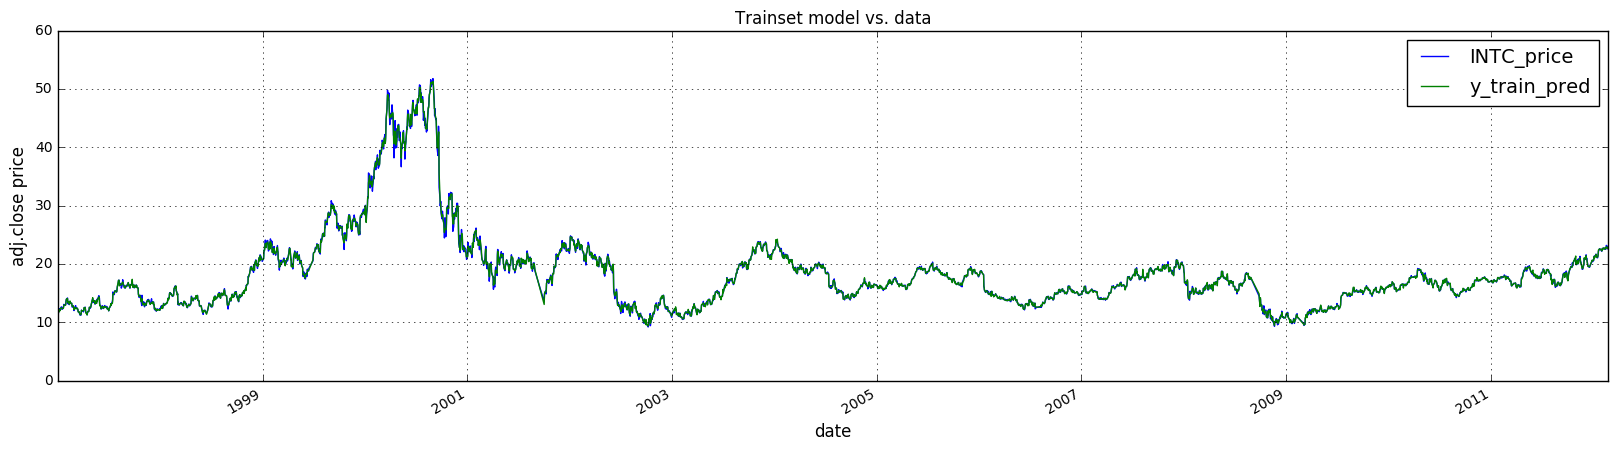

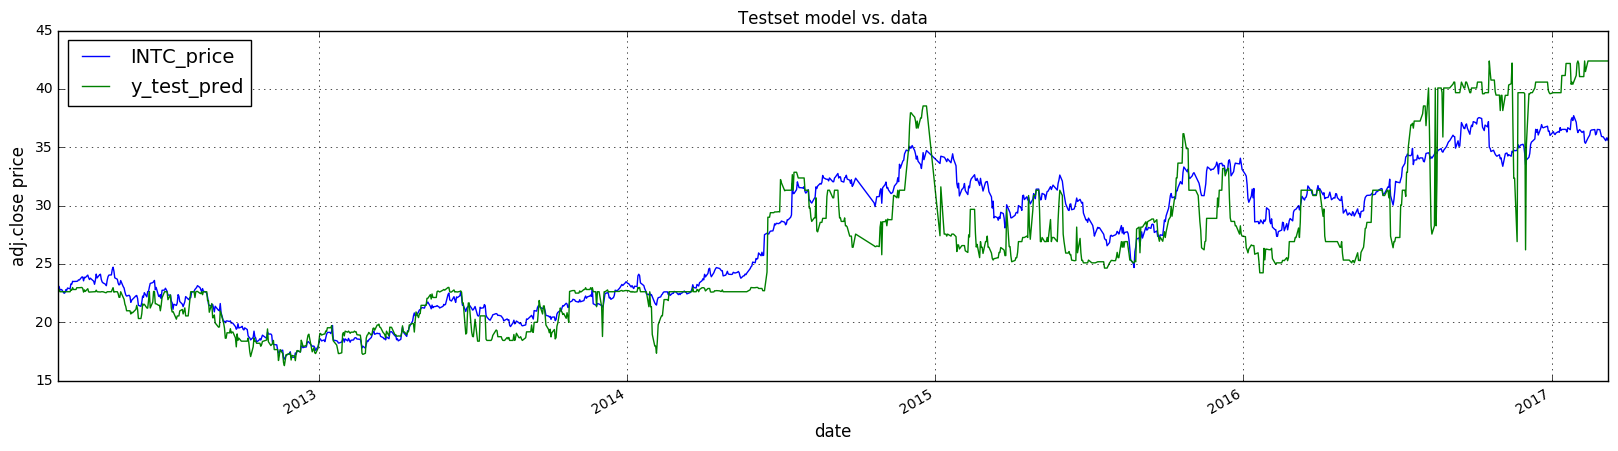

In [31]:
#Baseline model, knn regressor

from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=3)

train_predict_evaluate(regressor,X_train, y_train, X_test)

##### baseline knn shows poor performance. 


### 4.1.2. RandomForest regressor


****Evaluation of regression in testset****
R^2 == 0.622674363281
RMSE== 3.56997764488


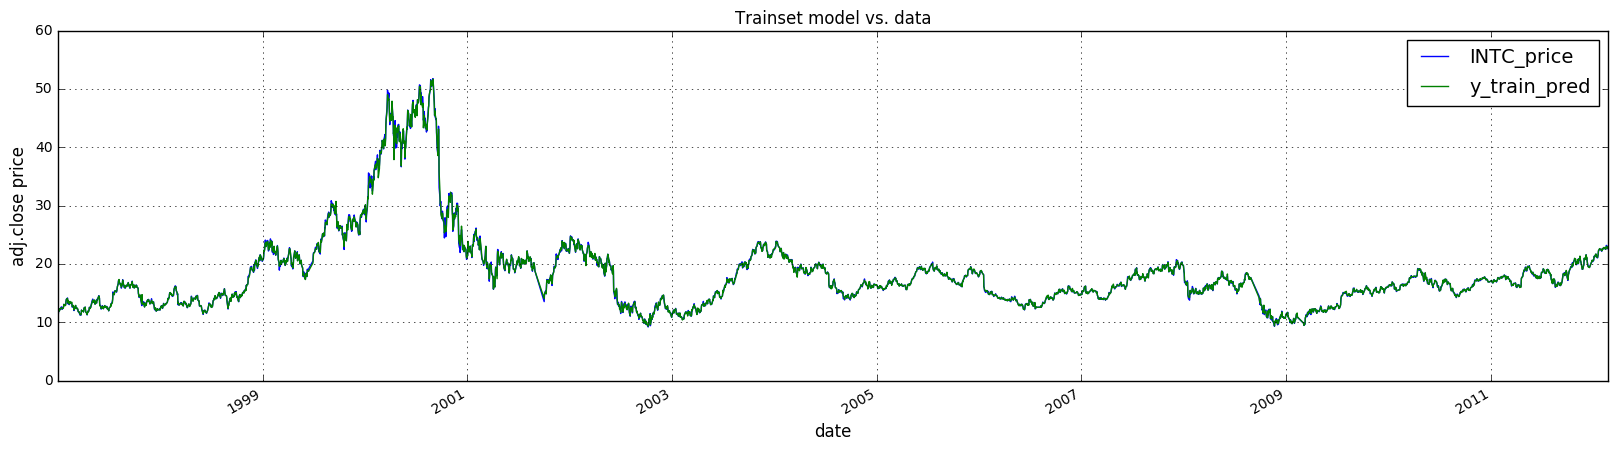

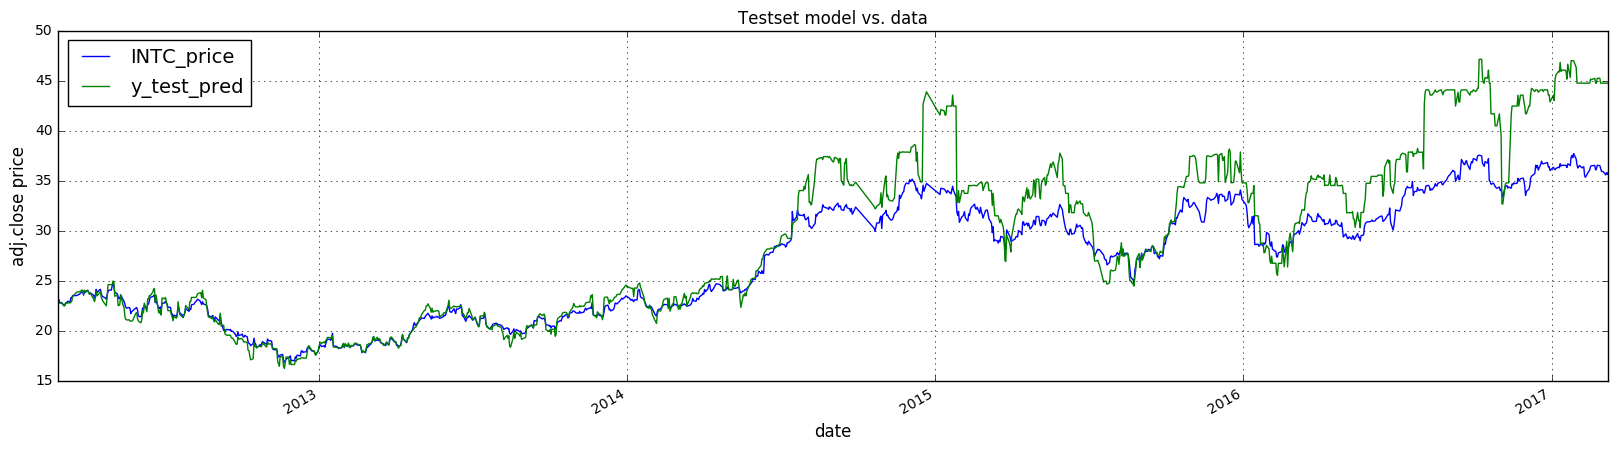

In [32]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor()
train_predict_evaluate(regressor,X_train, y_train,X_test)

In [33]:
#For randomforest regressor; feature importance in rank 

feat_imprt=regressor.feature_importances_
features=np.array(X_train.columns)
featTable=np.vstack((features,feat_imprt))
featTable
ft=pd.DataFrame(featTable.T,columns=['features','values'])
ft.sort_values(by='values',ascending=False)

,features,values
2,EMA_fast,0.907967
0,Bollinger_lowerband,0.0616064
5,RSI,0.0145568
11,SPY_price,0.00666177
1,Bollinger_upperband,0.00307618
8,SMA20,0.00164178
9,SMA200,0.00105845
10,SMA50,0.000864328
7,Rolling_std,0.000816368
6,Rolling_mean,0.000621028


### 4.1.3. Adaboost regressor with Decision tree

#### 4.1.3.1 Decision tree first 


****Evaluation of regression in testset****
R^2 == 0.634448677363
RMSE== 3.51383625595


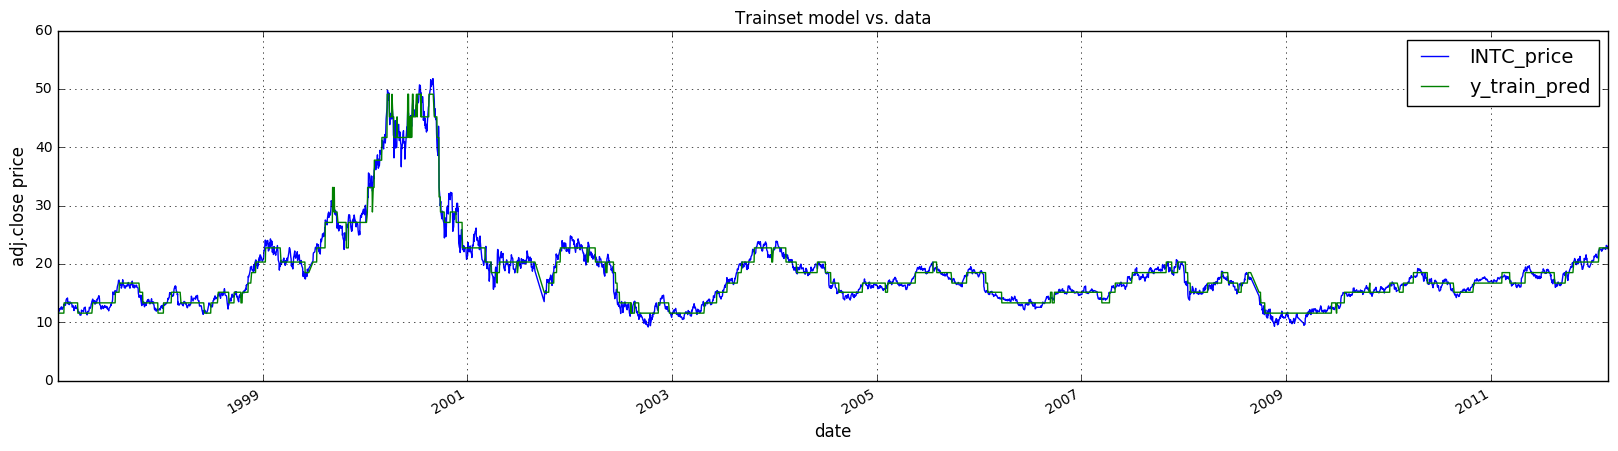

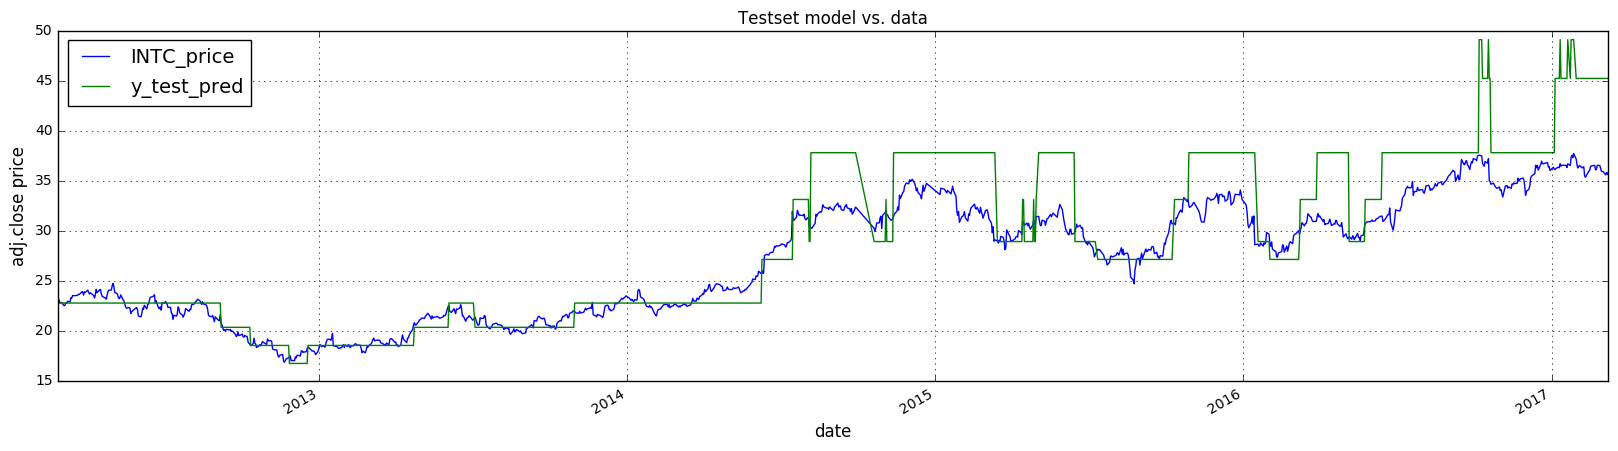

In [34]:
from sklearn.tree import DecisionTreeRegressor

rng = np.random.RandomState(1)
regressor= DecisionTreeRegressor(max_depth=4)

#Decision tree first
train_predict_evaluate(regressor,X_train, y_train,X_test)

#### 4.1.3.2 AdaBoost


****Evaluation of regression in testset****
R^2 == 0.799059299817
RMSE== 2.60520135517


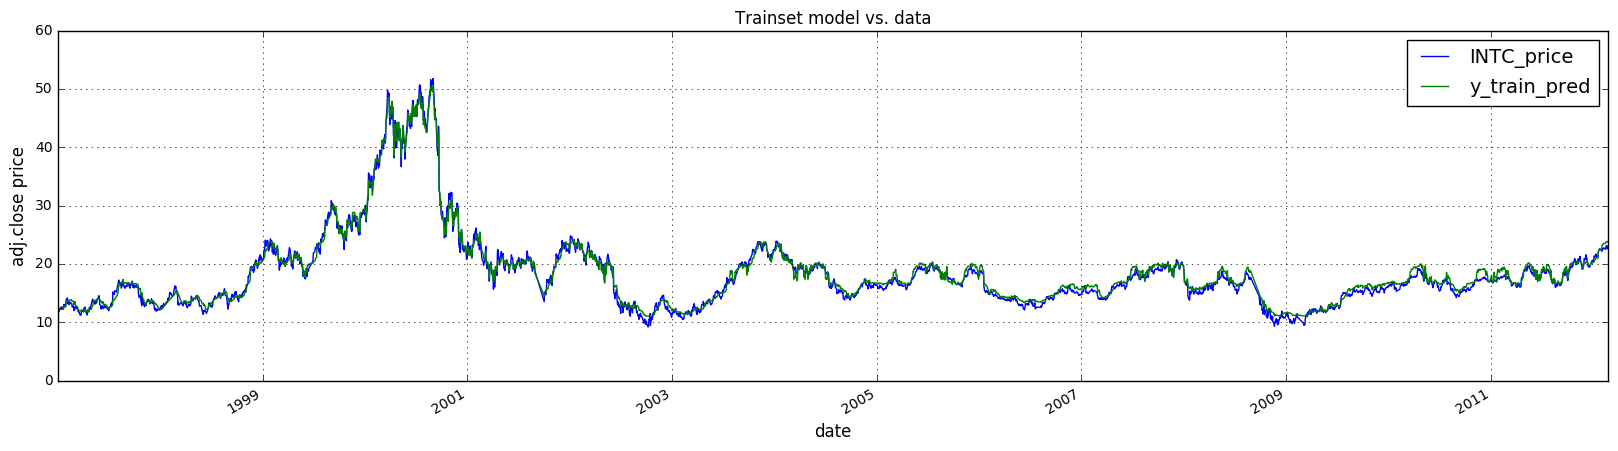

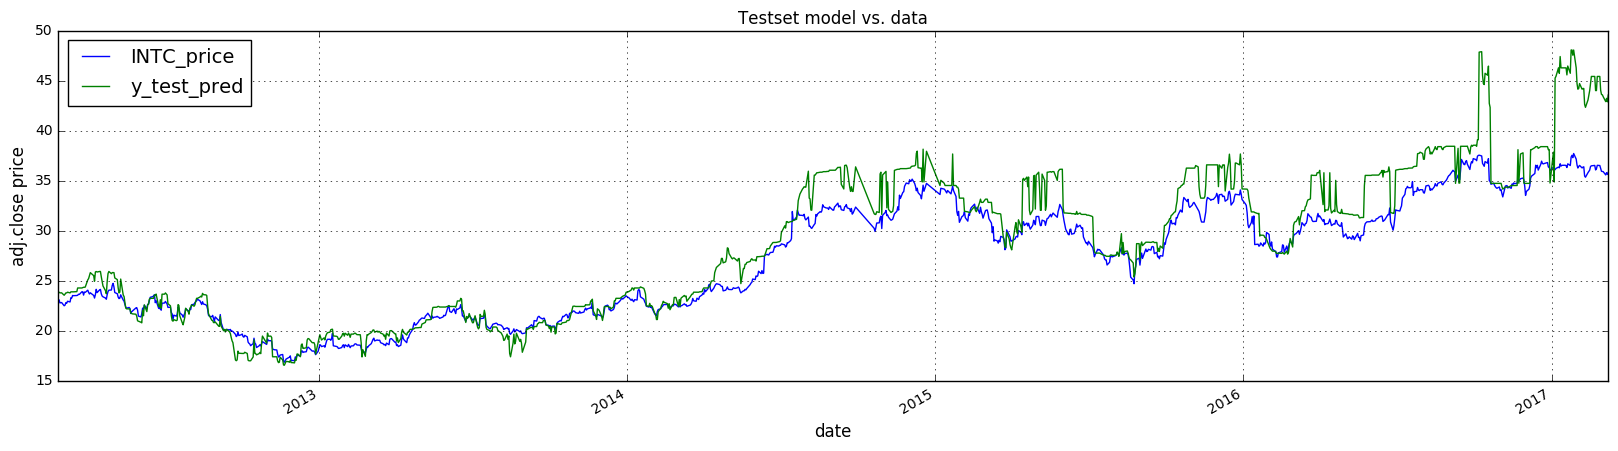

In [35]:
from sklearn.ensemble import AdaBoostRegressor

regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

train_predict_evaluate(regressor,X_train, y_train,X_test)

### 4.1.4 SVR regressor


****Evaluation of regression in testset****
R^2 == 0.881742189448
RMSE== 1.99858331241


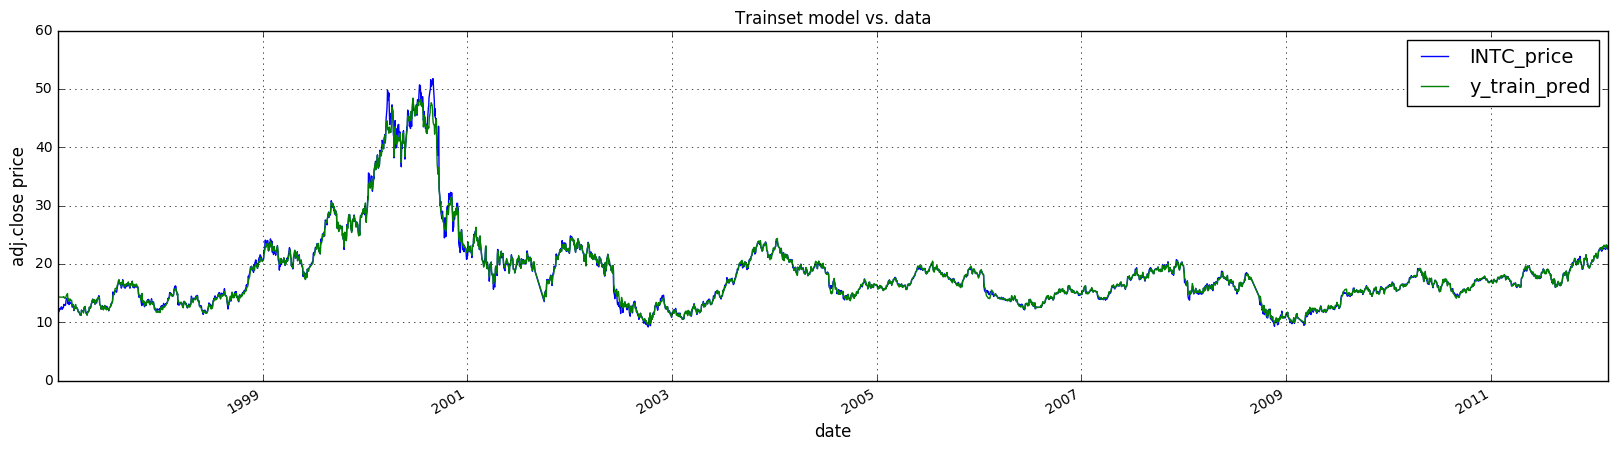

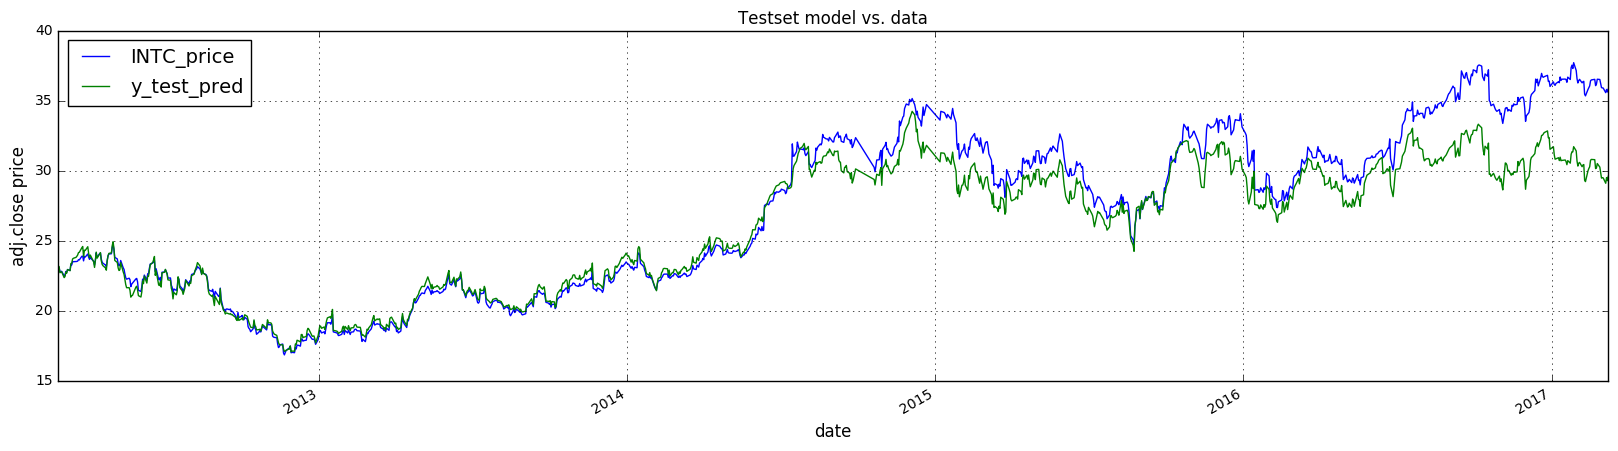

In [36]:
from sklearn.svm import SVR

np.random.seed(0)
regressor= SVR()#C=1.0, epsilon=0.2

train_predict_evaluate(regressor,X_train, y_train,X_test)

### Summary of PRICE regression 

,regressor,RMSE
2,SVR,1.998583
3,AdaBoostRegressor,2.605201
1,KNeighborsRegressor,2.754132
0,DecisionTreeRegressor,3.513836
4,RandomForestRegressor,3.569978


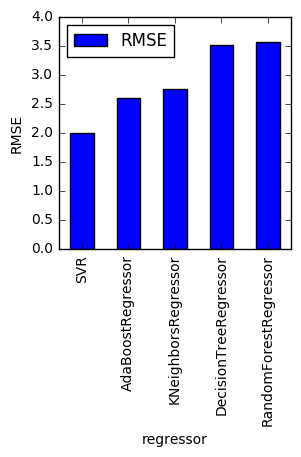

In [37]:
#summary of RMSE for all regressors
plt.rcParams['figure.figsize'] = (3.0, 3.0)
regressor_RMSE_df=pd.DataFrame(list(regressor_RMSE.iteritems()), columns=['regressor','RMSE'])

regressor_RMSE_df=regressor_RMSE_df.sort_values(by=['RMSE'],ascending=True)
display(regressor_RMSE_df)

ax=regressor_RMSE_df.plot(x=regressor_RMSE_df['regressor'],kind='bar')
ax.set_ylabel('RMSE')

For price regression, SVR gives the best performance. 

#### 4.1.4 Summary of regression on PRICE, RETURN AND LOG RETURN for all regressors used previously

In [38]:
display(X_train[:2]) 

,Bollinger_lowerband,Bollinger_upperband,EMA_fast,EMA_slow,MACD,RSI,Rolling_mean,Rolling_std,SMA20,SMA200,SMA50,SPY_price
1997-01-02,-1.06866,-1.029376,-1.086625,-1.028888,-0.522295,2.401139,-1.057851,-0.386246,-1.040967,-0.930978,-1.02576,-1.446264
1997-01-03,-1.06866,-1.029376,-1.086625,-1.028888,-0.522295,2.401139,-1.057851,-0.386246,-1.040967,-0.930978,-1.02576,-1.428854


In [39]:
# drop any NaN that previous dropna didn't take care of-Because log return doesn't want zero. 

index_INF= df_price.index[df_price["log_Return_28day"].apply(np.isinf)]
print index_INF.strftime("%Y-%m-%d")

index_INF= df_price.index[df_price["log_Return_14day"].apply(np.isinf)]
print index_INF.strftime("%Y-%m-%d")

index_INF= df_price.index[df_price["log_Return_7day"].apply(np.isinf)]
print index_INF.strftime("%Y-%m-%d")

print df_price.shape

[]
[]
[]
(4929, 20)


In [40]:
#Merge, feature scaling, and split train,testset

df_merged=df_price.join(df_features, how='inner')
print df_merged.shape,"\n",df_merged.columns.values

X = pd.DataFrame([  
                    df_merged['Bollinger_lowerband'], 
                    df_merged['Bollinger_upperband'], 
                    df_merged['EMA_fast'],
                    df_merged['EMA_slow'],
                    df_merged['MACD'], 
                    df_merged['RSI'], 
                    df_merged['Rolling_mean'],
                    df_merged['Rolling_std'], 
                    df_merged['SMA20'], 
                    df_merged['SMA200'], 
                    df_merged['SMA50'], 
                    df_merged['SPY_price']      
                 ]).transpose()

X_z=X.apply(zscore)

for train_index, test_index in tscv.split(X):
        X_train, X_test = X_z.iloc[train_index], X_z.iloc[test_index]
print "train_index, test_index\n", train_index, "\n", test_index

(4929, 32) 
['Open_SPY' 'High_SPY' 'Low_SPY' 'Close_SPY' 'Volume_SPY' 'Adj Close_SPY'
 'Open_INTC' 'High_INTC' 'Low_INTC' 'Close_INTC' 'Volume_INTC'
 'Adj Close_INTC' 'Return_1day' 'Return_7day' 'Return_14day' 'Return_28day'
 'log_Return_1day' 'log_Return_7day' 'log_Return_14day' 'log_Return_28day'
 'Bollinger_lowerband' 'Bollinger_upperband' 'EMA_fast' 'EMA_slow' 'MACD'
 'RSI' 'Rolling_mean' 'Rolling_std' 'SMA20' 'SMA200' 'SMA50' 'SPY_price']
train_index, test_index
[   0    1    2 ..., 3694 3695 3696] 
[3697 3698 3699 ..., 4926 4927 4928]


In [41]:
print "\nEvaluation of regression in testset:\n"

def return_train_predict_evaluate(regressor,X_train, y_train, X_test, key):
    regressor.fit(X_train, y_train)
    y_train_pred=regressor.predict(X_train)
    y_test_pred=regressor.predict(X_test)
   
    #Evaluation of regression
    
    Rsqr=regressor.score(X_test,y_test)
    RMSE=np.sqrt((np.sum((y_test_pred-y_test)**2))/len(y_test_pred))

    #R square=(1 - u/v), where u is the regression sum of squares ((y_true - y_pred) ** 2).sum() 
    #and v is the residual sum of squares ((y_true - y_true.mean()) ** 2).sum()
    #R^2=coefficient of determination of the prediction in test set
    #print "R^2 ==",Rsqr
    #print "RMSE==",RMSE
    #return_regressor_RMSE.update({regressor.__class__.__name__: RMSE})
    
    all_regressor_RMSE.update({key: RMSE})
 

    ##convert np array to df to plot together 
    df_train_pred = pd.DataFrame({'y_train_pred':y_train_pred}, index=y_train.index)
    df_train_pred.head(2)

    df_merged_trainPred=y_train.to_frame('INTC_price').join(df_train_pred)
    df_merged_trainPred.head(2)
    
    return RMSE


targetlist=['Adj Close_INTC','Return_7day','Return_14day','Return_28day',
            'log_Return_7day','log_Return_14day','log_Return_28day']

regressorlist=[KNeighborsRegressor(n_neighbors=3),
               RandomForestRegressor(),DecisionTreeRegressor(max_depth=4),
               AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=300, random_state=rng),
               SVR()
              ]

for target in targetlist:
    for regressor in regressorlist:
    
        y = df_merged[target]
        y_train, y_test = y[train_index], y[test_index]
        regressor=regressor

        if target.startswith('Return'):
            returnDays=int(target.strip('Return_').strip('day'))
            key=regressor.__class__.__name__+'_Return_'+str(returnDays)
        elif target.startswith('log'):
            returnDays=int(target.strip('log_Return_').strip('day')) 
            key=regressor.__class__.__name__+'_log_Return_'+str(returnDays)
        else: 
            returnDays=0
            key=regressor.__class__.__name__+'_Price'

        RMSE=return_train_predict_evaluate(regressor,X_train, y_train,X_test,key)
        print key, "RMSE=",RMSE
    
print all_regressor_RMSE       



Evaluation of regression in testset:

KNeighborsRegressor_Price RMSE= 2.75413236047
RandomForestRegressor_Price RMSE= 4.01491734686
DecisionTreeRegressor_Price RMSE= 3.2837653351
AdaBoostRegressor_Price RMSE= 2.55233954594
SVR_Price RMSE= 1.99858331241
KNeighborsRegressor_Return_7 RMSE= 0.0413658280224
RandomForestRegressor_Return_7 RMSE= 0.0405972056599
DecisionTreeRegressor_Return_7 RMSE= 0.0392084239189
AdaBoostRegressor_Return_7 RMSE= 0.0532119648248
SVR_Return_7 RMSE= 0.0341476307042
KNeighborsRegressor_Return_14 RMSE= 0.0391499272234
RandomForestRegressor_Return_14 RMSE= 0.0277690016918
DecisionTreeRegressor_Return_14 RMSE= 0.0389265927099
AdaBoostRegressor_Return_14 RMSE= 0.0305575339615
SVR_Return_14 RMSE= 0.0334163472938
KNeighborsRegressor_Return_28 RMSE= 0.0743229834531
RandomForestRegressor_Return_28 RMSE= 0.0536339507599
DecisionTreeRegressor_Return_28 RMSE= 0.0582341734053
AdaBoostRegressor_Return_28 RMSE= 0.0542968227352
SVR_Return_28 RMSE= 0.0507939479931
KNeighborsReg

,key,RMSE
0,RandomForestRegressor_Return_14,0.027769
10,AdaBoostRegressor_Return_14,0.030558
7,SVR_Return_14,0.033416
3,SVR_Return_7,0.034148
14,DecisionTreeRegressor_Return_14,0.038927
18,KNeighborsRegressor_Return_14,0.039150
19,DecisionTreeRegressor_Return_7,0.039208
33,RandomForestRegressor_Return_7,0.040597
1,KNeighborsRegressor_Return_7,0.041366
5,SVR_Return_28,0.050794


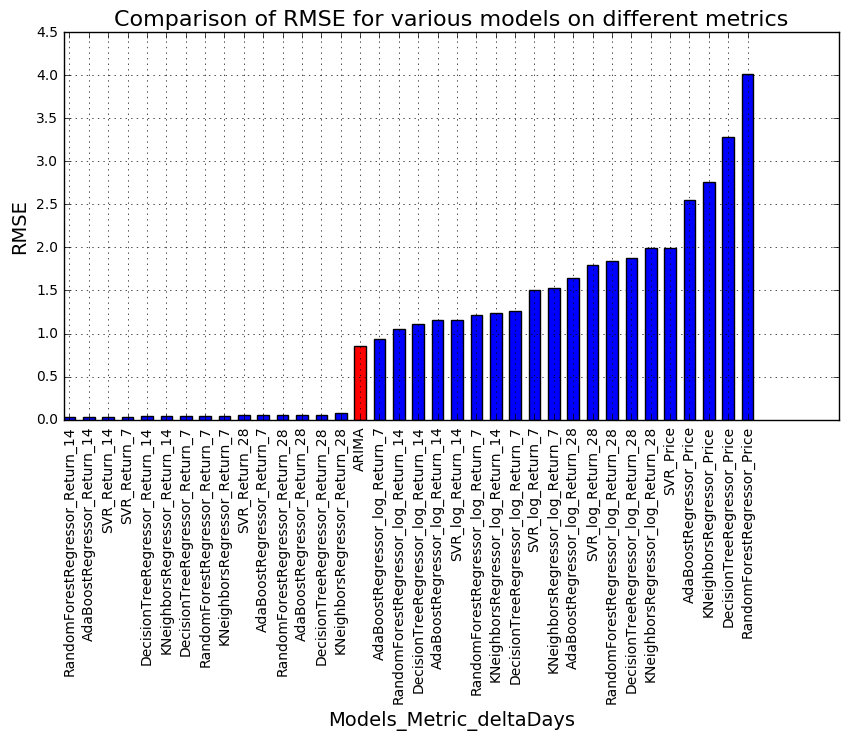

In [42]:
#summary of RMSE for all regressors

all_regressor_RMSE_df=pd.DataFrame(list(all_regressor_RMSE.iteritems()), columns=['key','RMSE'])
all_regressor_RMSE_df=all_regressor_RMSE_df.sort_values(by=['RMSE'],ascending=True)

plt.rcParams['figure.figsize'] = (10.0, 5.0)

colors = []
for model in all_regressor_RMSE_df.key: 
    if model.startswith('ARIMA'):
        colors.append('r')
    else:
        colors.append('b')

#ax=all_regressor_RMSE_df.plot(x=all_regressor_RMSE_df['key'],kind='bar')
ind = np.arange(len(all_regressor_RMSE))
fig = plt.figure()
ax = fig.add_subplot(111)
bar_width = 0.6
ax.bar(ind,all_regressor_RMSE_df['RMSE'], width=bar_width, color=colors) #all_regressor_RMSE_df['key'],

ax.set_ylabel('RMSE',fontsize=14)
ax.set_xlabel('Models_Metric_deltaDays',fontsize=14)
plt.xticks(ind + bar_width / 2, all_regressor_RMSE_df['key'],rotation='vertical')

ax.grid('on')
ax.set_title('Comparison of RMSE for various models on different metrics',fontsize=16)


display(all_regressor_RMSE_df)

***This concludes that RandomForestRegressor, AdaBoostRegressor, SVR on Return of 14days gives the best performance on regression.***

# Classification

Some parts of workflow is refered from this tutorial:
#http://francescopochetti.com/stock-market-prediction-part-introduction/


### Data preprocessing to include open and close eventually for investment backtesting

In [65]:
#http://francescopochetti.com/stock-market-prediction-part-introduction/
import cPickle


import numpy as np
import pandas as pd
import datetime
from datetime import datetime
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import TimeSeriesSplit
from collections import Counter
import operator
from IPython.display import display
from sklearn.qda import QDA
import re
from dateutil import parser
from backtest import Strategy, Portfolio
import quandl 
import os
import sys

print os.getcwd()

/Users/parksoy/Desktop/GoogleDrive_Soyoung/Udacity_nanoDegree_MachineLearning/capstone


In [66]:
print df_merged.columns

Index([u'Open_SPY', u'High_SPY', u'Low_SPY', u'Close_SPY', u'Volume_SPY',
       u'Adj Close_SPY', u'Open_INTC', u'High_INTC', u'Low_INTC',
       u'Close_INTC', u'Volume_INTC', u'Adj Close_INTC', u'Return_1day',
       u'Return_7day', u'Return_14day', u'Return_28day', u'log_Return_1day',
       u'log_Return_7day', u'log_Return_14day', u'log_Return_28day',
       u'Bollinger_lowerband', u'Bollinger_upperband', u'EMA_fast',
       u'EMA_slow', u'MACD', u'RSI', u'Rolling_mean', u'Rolling_std', u'SMA20',
       u'SMA200', u'SMA50', u'SPY_price', u'UpDown'],
      dtype='object')


In [67]:
#Ensure the same data is used

X = pd.DataFrame([  
                    df_merged['Bollinger_lowerband'], 
                    df_merged['Bollinger_upperband'], 
                    df_merged['EMA_fast'],
                    df_merged['EMA_slow'],
                    df_merged['MACD'], 
                    df_merged['RSI'], 
                    df_merged['Rolling_mean'],
                    df_merged['Rolling_std'], 
                    df_merged['SMA20'], 
                    df_merged['SMA200'], 
                    df_merged['SMA50'], 
                    df_merged['SPY_price']      
                 ]).transpose()

X_z=X.apply(zscore)
print X.shape

(4929, 12)


In [68]:
targetlist=['Adj Close_INTC','Return_1day','Return_7day','Return_14day','Return_28day',
            'log_Return_7day','log_Return_14day','log_Return_28day']

target='Return_1day'
y_cont = df_merged[target].to_frame()

display(y_cont[:2])
le = preprocessing.LabelEncoder()
df_merged['UpDown']=df_merged[target]
df_merged.UpDown[df_merged.UpDown>=0]=1#0
df_merged.UpDown[df_merged.UpDown<0]=0#1

#df_merged.UpDown = le.fit(df_merged.UpDown).transform(df_merged.UpDown)
y = pd.DataFrame(df_merged.UpDown, index=df_merged.index)
concat=y_cont.join(y)
display(concat[:10])
print y.shape

,Return_1day
1997-01-02,0.061361
1997-01-03,0.061361


/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Return_1day,UpDown
1997-01-02,0.061361,1.0
1997-01-03,0.061361,1.0
1997-01-06,0.003613,1.0
1997-01-07,0.032403,1.0
1997-01-08,-0.007847,0.0
1997-01-09,0.005272,1.0
1997-01-10,0.010490,1.0
1997-01-13,0.016436,1.0
1997-01-14,0.001702,1.0
1997-01-15,-0.034834,0.0


(4929, 1)


In [69]:
print Counter(df_merged['UpDown']) #balanced dataset.
print df_merged.shape

Counter({1.0: 2564, 0.0: 2365})
(4929, 33)


In [91]:
def makeBinary(target):
     
    target='Return_1day'
    y_cont = df_merged[target].to_frame()

    df_merged['UpDown']=df_merged[target]
    df_merged.UpDown[df_merged.UpDown>=0]=1
    df_merged.UpDown[df_merged.UpDown<0]=0

    y = pd.DataFrame(df_merged.UpDown, index=df_merged.index)

    return y
    
y=makeBinary(target)

print X.shape,X_z.shape
for train_index, test_index in tscv.split(X):
        X_train, X_test = X_z.iloc[train_index], X_z.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
print "train_index, test_index\n", train_index, "\n", test_index
print X_train.shape, X_test.shape
display(X_train[:1])
display(y_train[:1])
display(X_train[-1:])
display(y_train[-1:])

print X_train.shape, y_train.shape, X_test.shape, y_test.shape
display(X_test[:1])
display(y_test[:1])
display(X_test[-1:])
display(y_test[-1:])


(4929, 3) (4929, 3)
train_index, test_index
[   0    1    2 ..., 3694 3695 3696] 
[3697 3698 3699 ..., 4926 4927 4928]
(3697, 3) (1232, 3)


/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,RSI,MACD,SPY_price
1997-01-02,2.401139,-0.522295,-1.446264


,UpDown
1997-01-02,1.0


,RSI,MACD,SPY_price
2012-02-24,0.28704,0.193461,0.232991


,UpDown
2012-02-24,1.0


(3697, 3) (3697, 1) (1232, 3) (1232, 1)


,RSI,MACD,SPY_price
2012-02-27,0.535739,0.123408,0.237849


,UpDown
2012-02-27,1.0


,RSI,MACD,SPY_price
2017-03-09,-0.580089,-0.104219,2.886253


,UpDown
2017-03-09,1.0


In [71]:
#https://miguelmalvarez.com/2015/02/23/python-and-kaggle-feature-selection-multiple-models-and-grid-search/
from sklearn.feature_selection import VarianceThreshold
from collections import Counter

# Fitting a feature selector
def feature_selection(X):
    selector = VarianceThreshold()
    selector.fit(X)
    print('Number of features used... ' +
              str(Counter(selector.get_support())[True]))
    print('Number of features ignored... ' +
              str(Counter(selector.get_support())[False]))
    return selector


#Learn the features to filter from train set
fs = feature_selection(X)
 
#Transform train and test subsets
train_instances = fs.transform(X)

Number of features used... 12
Number of features ignored... 0


In [72]:
#Before running classification on 12 features for extensive gridsearchCV, run randomforest to understand feature importance

clf=RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train)
importance=clf.feature_importances_
indices = np.argsort(importance)[::-1]
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importance[indices[f]]))

/Users/parksoy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


1. feature RSI (0.184370)
2. feature MACD (0.099612)
3. feature SPY_price (0.082577)
4. feature Rolling_std (0.078505)
5. feature SMA50 (0.073893)
6. feature SMA200 (0.073204)
7. feature EMA_slow (0.070846)
8. feature Bollinger_lowerband (0.069334)
9. feature Bollinger_upperband (0.068601)
10. feature EMA_fast (0.067690)
11. feature Rolling_mean (0.065867)
12. feature SMA20 (0.065501)


In [73]:
#Decided to learn only on RSI, MACD, SPY_price
X=X[['RSI','MACD',"SPY_price"]]

In [74]:
display(X[:2])
display(y[:2])
print X.shape,y.shape
y=y.as_matrix().ravel()

,RSI,MACD,SPY_price
1997-01-02,80.86643,-0.448408,51.586402
1997-01-03,80.86643,-0.448408,52.326773


,UpDown
1997-01-02,1.0
1997-01-03,1.0


(4929, 3) (4929, 1)


In [92]:
# Returns the best model from a set of model families given
# training data using cross-validation.
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

tscv = TimeSeriesSplit(n_splits=3)
classifiers_f1={}
tunned_estimators={}

from sklearn import preprocessing

# Returns the best configuration for a model using crosvalidation and grid search
def best_hyperparameter(model, parameters, X, y):
    print 'Grid search for... ' , model.__class__.__name__, 'in the space : ',parameters
    cv=tscv.split(X)
    grid_search = GridSearchCV(model, parameters, cv=cv, scoring="f1", verbose=1, n_jobs=-1)
    grid_search.fit(X, y)
    best_estimator = grid_search.best_estimator_
    print "........Best_hyperparameter_set=",str(grid_search.best_params_), "with f1 score=",grid_search.best_score_
    classifiers_f1.update({best_estimator.__class__.__name__: grid_search.best_score_})
    tunned_estimators.update({best_estimator: grid_search.best_score_})
    
    return [best_estimator,  grid_search.best_score_, str(grid_search.best_params_)]


def best_model(set_model_hyperparameter, X, y):
    best_score = 0.0
    best_model_score_param = None
    model_score_parameter = []
    
    for name, model, parameters in set_model_hyperparameter:
        model_score_parameter.append(best_hyperparameter(model,parameters,X,y))
 
    for model, score, parameter in model_score_parameter:
        if (score > best_score):
            best_score = score
            best_model_score_param = [model, score, parameter]
 
    return best_model_score_param
 
def set_model_hyperparameter():
    set_model_param = []

    #RandomForest
    rf_parameters = [{"n_estimators": [10, 100], #, 250
                      'bootstrap': [False,True]}]
    set_model_param.append(["RandomForest",RandomForestClassifier(n_jobs=-1),rf_parameters])
    
    
    #Knn
    knn_parameters = [{"n_neighbors": [3, 5],
                       'leaf_size': [10,30,50] }]
    set_model_param.append(["kNN", neighbors.KNeighborsClassifier(n_jobs=-1),knn_parameters])
    
    #Logistic
    logistic_parameters=[{'C': [0.01,0.1,1.0],
                          'solver': ['liblinear','sag']}]
    set_model_param.append(["logistic", LogisticRegression(n_jobs=-1),logistic_parameters])
    
    #Adaboost
    adaboost_parameters=[{'learning_rate': [0.05,0.5,1.0],
                          'n_estimators': [5,50]}]
    set_model_param.append(["adaboost", AdaBoostClassifier(),adaboost_parameters])
    
    #GradientBoost
    gboosting_parameters=[{'learning_rate': [0.01,0.1,1],
                           'max_depth': [3,10],
                           'n_estimators': [10,100]}]
    set_model_param.append(["gboosting", GradientBoostingClassifier(),gboosting_parameters])
    
    #XGBoost
    xgb_parameters=[{'gamma': [0,1],
                     'learning_rate': [0.01,0.1,1],
                     'max_depth': [3,10],
                     'n_estimators': [10,100]}]
    set_model_param.append(["xgb", XGBClassifier(),xgb_parameters])
    
    '''
    #SVC: Takes forever. 
    svm_parameters = [{'kernel': ['poly','rbf'],
                       'degree': [1, 2]}]
    set_model_param.append(["SVM", SVC(),svm_parameters])
    '''

    return set_model_param
    

set_model_hyperparameter=set_model_hyperparameter()
best_model=best_model(set_model_hyperparameter, X_train, y_train)

print "\n************RESULT OF BEST_MODEL:******************\n", 
print "Best_model: ", best_model[0],
print ""
print "\nBest_f1_score: ", best_model[1],
print "\nBest_hyperparameter: ",best_model[2]

Grid search for...  RandomForestClassifier in the space :  [{'n_estimators': [10, 100], 'bootstrap': [False, True]}]
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: DataCon

........Best_hyperparameter_set= {'n_estimators': 100, 'bootstrap': True} with f1 score= 0.576298198835
Grid search for...  KNeighborsClassifier in the space :  [{'n_neighbors': [3, 5], 'leaf_size': [10, 30, 50]}]
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:238: Data

........Best_hyperparameter_set= {'n_neighbors': 5, 'leaf_size': 10} with f1 score= 0.585061149805
Grid search for...  LogisticRegression in the space :  [{'C': [0.01, 0.1, 1.0], 'solver': ['liblinear', 'sag']}]
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.6s finished
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/model_selection/_search.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  best_estimator.fit(X, y, **self.fit_params)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: Da

........Best_hyperparameter_set= {'C': 0.1, 'solver': 'sag'} with f1 score= 0.641445228516
Grid search for...  AdaBoostClassifier in the space :  [{'n_estimators': [5, 50], 'learning_rate': [0.05, 0.5, 1.0]}]
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.1s finished


........Best_hyperparameter_set= {'n_estimators': 5, 'learning_rate': 1.0} with f1 score= 0.612650809609
Grid search for...  GradientBoostingClassifier in the space :  [{'n_estimators': [10, 100], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 10]}]
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    8.4s finished


........Best_hyperparameter_set= {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 3} with f1 score= 0.637001768477
Grid search for...  XGBClassifier in the space :  [{'n_estimators': [10, 100], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 10], 'gamma': [0, 1]}]
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

........Best_hyperparameter_set= {'n_estimators': 10, 'learning_rate': 0.1, 'max_depth': 3, 'gamma': 1} with f1 score= 0.637396458668

************RESULT OF BEST_MODEL:******************
Best_model:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False) 

Best_f1_score:  0.641445228516 
Best_hyperparameter:  {'C': 0.1, 'solver': 'sag'}


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    4.1s finished
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/parksoy/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [93]:
hyperparamtunned_classifiers=sorted(tunned_estimators.items(), key=operator.itemgetter(1), reverse=True)

print hyperparamtunned_classifiers[0][0]

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)


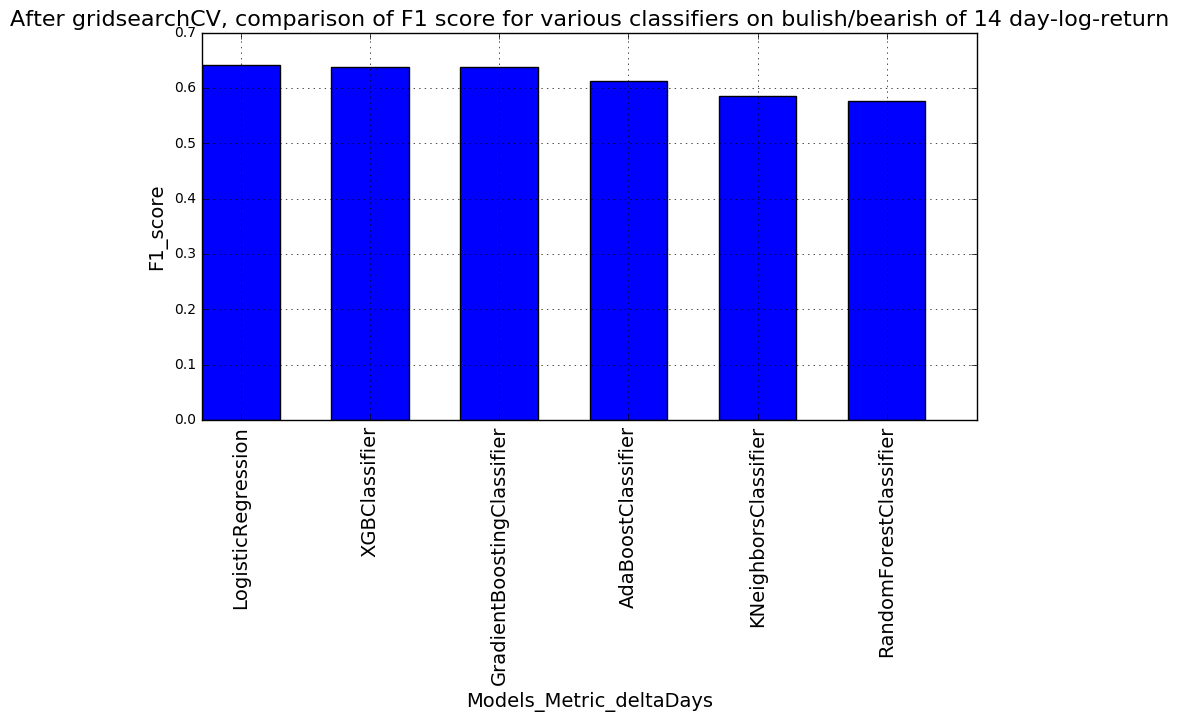

,key,f1_score
0,LogisticRegression,0.641445
2,XGBClassifier,0.637396
5,GradientBoostingClassifier,0.637002
4,AdaBoostClassifier,0.612651
1,KNeighborsClassifier,0.585061
3,RandomForestClassifier,0.576298


In [94]:
#summary of f1 score for all classifiers

import matplotlib.pyplot as plt

classifiers_f1_df=pd.DataFrame(list(classifiers_f1.iteritems()), columns=['key','f1_score'])
classifiers_f1_df=classifiers_f1_df.sort_values(by=['f1_score'],ascending=False)

plt.rcParams['figure.figsize'] = (10.0, 5.0)

colors = []
for model in classifiers_f1_df.key: 
    if model.startswith('KNeighbors'):
        colors.append('b')
    else:
        colors.append('b')

ind = np.arange(len(classifiers_f1))
fig = plt.figure()
ax = fig.add_subplot(111)
bar_width = 0.6
ax.bar(ind,classifiers_f1_df['f1_score'], width=bar_width, color=colors) 

ax.set_ylabel('F1_score',fontsize=14)
ax.set_xlabel('Models_Metric_deltaDays',fontsize=14)
plt.xticks(ind + bar_width / 2, classifiers_f1_df['key'],rotation='vertical',fontsize=14)

ax.grid('on')
ax.set_title('After gridsearchCV, comparison of F1 score for various classifiers on bulish/bearish of 14 day-log-return',fontsize=16)
plt.show()

display(classifiers_f1_df[:10])

# AFTER BEST MODEL SELECTION-predict!!
### Run model for the entire trainset and save the model in pickle. Understand feature importance at the end

In [95]:
################################################################################
# AFTER BEST MODEL SELECTION
bestlags = 7#9
bestdelta = 5#9
savemodel = True
##############################################################################
parameters=[]

from datetime import datetime
from sklearn.metrics import f1_score

def perform_bestmodelClassification(X_train, y_train, X_test, y_test, method, savemodel):

    y_train=y_train.as_matrix().ravel()
    y_test=y_test.as_matrix().ravel()
    
    clf = method
    clf.fit(X_train, y_train)
   
    if clf==RandomForestClassifier(n_estimators=1000, n_jobs=-1):
        importance=clf.feature_importances_
        indices = np.argsort(importance)[::-1]
        for f in range(X_train.shape[1]):
            print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importance[indices[f]]))
    if savemodel == True:
        fname_out = '{}-{}.pickle'.format(symbol, datetime.now())
        with open(fname_out, 'wb') as f:
            cPickle.dump(clf, f, -1)    
    
    y_pred=clf.predict(X_test)
    acc_score=clf.score(X_test, y_test)
    f1score=f1_score(y_test, y_pred)
    
    classifiers_f1.update({method.__class__.__name__: f1score})
    return y_pred, acc_score,f1score


y_pred, acc_score,f1score=perform_bestmodelClassification(X_train, y_train, 
                                                  X_test, y_test, 
                                                  hyperparamtunned_classifiers[0][0], savemodel=True) #best_model[0]

print "Accuracy of the testset=", acc_score
print "F1_score of the testset=",f1score

Accuracy of the testset= 0.63474025974
F1_score of the testset= 0.706266318538


In [96]:
import glob

list_pickle=glob.glob("./*.pickle")
bestModel_pickles=[pickle for pickle in list_pickle if pickle.find(symbol)!=-1]
bestModel_pickle=sorted(bestModel_pickles)[-1]
print bestModel_pickle

./INTC-2017-04-03 16:29:45.303578.pickle


# Prediction From BestModel.pickle

In [97]:
#PREDICTION
from sklearn import metrics

# calls the best model previously saved in pickle file and runs it on the test set 
# retutning an array of 0,1 (Down, Up) according to predicted returns

def retrieve_FromBestModelPickle(X_test, y_test, bestModel_pickle):
    """returns array of prediction and score from best model."""
    with open(bestModel_pickle, 'rb') as fin:
        model = cPickle.load(fin)
        
    y_pred=model.predict(X_test)
    acc_score=model.score(X_test, y_test)
    f1score=f1_score(y_test, y_pred)  
    return f1score, y_pred

f1score,y_pred= retrieve_FromBestModelPickle(X_test, y_test, bestModel_pickle)#bestdelta, bestlags, [0]

print "f1_score of best model in testset=",f1score

prediction=pd.DataFrame({'pred':y_pred}, index=y_test.index)

df_ytest_pred=y_test.join(prediction)
display(df_ytest_pred[:3])

f1_score of best model in testset= 0.706266318538


,UpDown,pred
2012-02-27,1.0,1.0
2012-02-28,1.0,1.0
2012-02-29,0.0,1.0


# NOW TRADE!!!

In [98]:
# Read SPY, INTC complete data again

dates = pd.date_range(start_date, end_date)
df_empty = pd.DataFrame(index=dates)
print df_empty.shape

# dataframe of S&P 500 historical prices (saved locally from Yahho Finance)
df_empty = pd.DataFrame(index=dates)
df_INTC = pd.read_csv('./data/'+symbol+'.csv', index_col='Date', parse_dates=True) 
df_INTC=df_empty.join(df_INTC)
df_INTC=df_INTC.dropna()
bars=df_INTC

display(df_INTC[:2])
display(df_INTC[-2:])
print df_INTC.shape

df_empty = pd.DataFrame(index=dates)
df_SPY = pd.read_csv('./data/'+'SPY'+'.csv', index_col='Date', parse_dates=True)
df_SPY = df_empty.join(df_SPY)
df_SPY = df_SPY.dropna()

display(df_SPY[:2])
display(df_SPY[-2:])
print df_SPY.shape

(7373, 0)


,Open,High,Low,Close,Volume,Adj Close
1997-01-02,131.75,132.0,127.625,130.375,97639200.0,11.206980
1997-01-03,133.00,138.5,132.625,138.375,95648000.0,11.894656


,Open,High,Low,Close,Volume,Adj Close
2017-03-08,35.669998,35.900002,35.529999,35.619999,20899400.0,35.619999
2017-03-09,35.599998,35.939999,35.500000,35.820000,23543100.0,35.820000


(5080, 6)


,Open,High,Low,Close,Volume,Adj Close
1997-01-02,74.375,74.375,72.750000,74.031197,2031900.0,51.586402
1997-01-03,74.375,75.125,74.078102,75.093697,2123200.0,52.326773


,Open,High,Low,Close,Volume,Adj Close
2017-03-08,237.339996,237.639999,236.399994,236.559998,78168800.0,235.535317
2017-03-09,236.699997,237.240005,235.740005,236.860001,90683900.0,235.834020


(5080, 6)


In [99]:
class BacktestPortfolio(Portfolio):
    """Buys or sells 500 shares of an asset at the opening price of
    every bar, depending upon the direction of the forecast, 
    close out the trade at the close of the bar.

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    bars - A DataFrame of INTC bars
    signals - A pandas DataFrame of signals (1, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, symbol, bars, signals, initial_capital=100000.0, shares=500):
        self.symbol = symbol        
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.shares = int(shares)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        """Generate the positions/trade decision, based on the signals"""
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)
        positions[self.symbol] = self.shares*self.signals['signal']
        return positions
                    
    def backtest_portfolio(self):
        """Backtest the portfolio and return a "total" asset curve and the percentage returns."""
        portfolio = pd.DataFrame(index=self.positions.index)
        pos_diff = self.positions.diff()
            
        portfolio['price_diff'] = self.bars['Close']-self.bars['Open']
        #portfolio['price_diff'][0:5] = 0.0
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff'] #-4.95 
     
        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio
    

In [100]:
from collections import Counter
print Counter(y_test)
print y_test.shape
print Counter(y_pred)

Counter({'UpDown': 1})
(1232, 1)
Counter({1.0: 871, 0.0: 361})


In [101]:
import datetime

start_test = X_test.index[-1]  
end_period = X_test.index[0]  

# subset of the data corresponding to test set
start_test=start_test.strftime("%Y%m%d") 
end_period=end_period.strftime("%Y%m%d") 

#Get index of testset
bars = bars.loc[X_test.index] 
print "Start=",bars.index[0],"End=",bars.index[-1] #Start= 2012-03-02 00:00:00 End= 2017-03-08 00:00:00

# initialize empty dataframe indexed as the bars. 
signals = pd.DataFrame(index=bars.index) 
print "signals.shape =",signals.shape 

signals['signal_actual']=y_test
# Initialize signals.signal column to zero
signals['signal'] = 0.0

# Copying into signals.signal column results of prediction
signals['signal'] = y_pred

# replace the zeros with -1 (new encoding for Down day)
signals.signal[signals.signal==0]=-1

# compute the difference between consecutive entries in signals.signal. As
# signals.signal was an array of 1 and -1 return signals.positions will 
# be an array of 0s and 2s.
signals['positions'] = signals['signal'].diff()
signals['positions'][0]=0.0

df_buy = signals[signals['positions']==2]
df_sell = signals[signals['positions']==-2]
df_hold = signals[signals['positions']==0]

# Create a portfolio to calculate predicted returns and actual return
portfolio = BacktestPortfolio(symbol, bars, signals)

# Backtest the portfolio 
returns = portfolio.backtest_portfolio()

df_bar_signal_return=bars[['Open','Close']].join(returns)
df_bar_signal_return=df_bar_signal_return.join(signals)

display(df_bar_signal_return[:20])

Start= 2012-02-27 00:00:00 End= 2017-03-09 00:00:00
signals.shape = (1232, 0)


,Open,Close,price_diff,profit,total,returns,signal_actual,signal,positions
2012-02-27,26.520000,26.889999,0.369999,184.9995,100184.9995,NaN,1.0,1.0,0.0
2012-02-28,26.930000,27.240000,0.310000,155.0000,100339.9995,0.001547,1.0,1.0,0.0
2012-02-29,27.250000,26.879999,-0.370001,-185.0005,100154.9990,-0.001844,0.0,1.0,0.0
2012-03-02,26.900000,26.920000,0.020000,10.0000,100164.9990,0.000100,1.0,1.0,0.0
2012-03-05,26.910000,26.540001,-0.369999,184.9995,100349.9985,0.001847,0.0,-1.0,-2.0
2012-03-06,26.250000,26.610001,0.360001,180.0005,100529.9990,0.001794,1.0,1.0,2.0
2012-03-07,26.580000,26.910000,0.330000,165.0000,100694.9990,0.001641,1.0,1.0,0.0
2012-03-08,27.000000,26.840000,-0.160000,-80.0000,100614.9990,-0.000794,0.0,1.0,0.0
2012-03-09,26.940001,27.070000,0.129999,64.9995,100679.9985,0.000646,1.0,1.0,0.0
2012-03-12,27.000000,26.990000,-0.010000,-5.0000,100674.9985,-0.000050,0.0,1.0,0.0


In [102]:
print df_buy.shape
print df_sell.shape
print Counter(signals['positions'])

(60, 3)
(60, 3)
Counter({0.0: 1112, 2.0: 60, -2.0: 60})


# Plotting backtesting

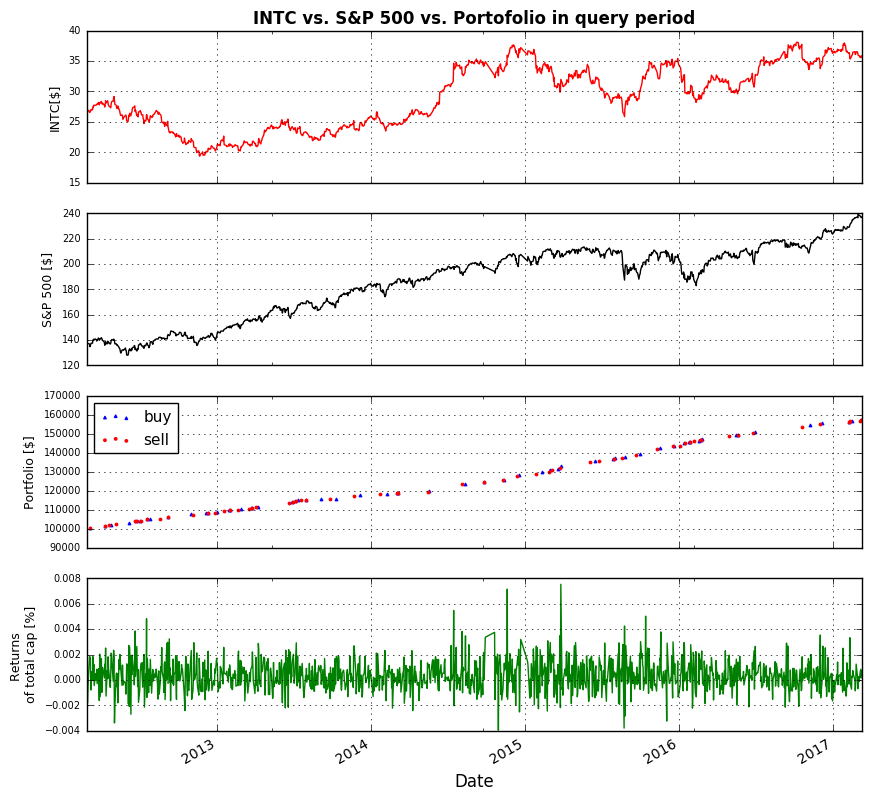

In [103]:
import matplotlib.pyplot as plt
import pylab as pl

plt.rcParams['figure.figsize'] = (10.0, 10.0)
# Plot results
f, ax = plt.subplots(4, sharex=True)

bars['Close'].plot(ax=ax[0], color='r') #, lw=3.
ax[0].set_title(symbol+' vs. S&P 500 vs. Portofolio in query period', fontsize=12, fontweight="bold")
ax[0].set_ylabel(symbol+"[$]", fontsize=9)
ax[0].set_xlabel('', fontsize=9)
ax[0].tick_params(axis='y', which='major', labelsize=7)
#ax[0].legend(('S&P-500',), loc='upper left', prop={"size":12})
ax[0].grid(True)


df_SPY['Close'].loc[X_test.index].plot(ax=ax[1],color='black')
ax[1].set_ylabel('S&P 500 [$]', fontsize=9)
ax[1].set_xlabel('Date', fontsize=12)
ax[1].grid(True)
ax[1].tick_params(axis='y', which='major', labelsize=7)



#returns['total'].plot(ax=ax[2], color=colors)  #, lw=3.
ax[2].scatter(df_buy.index,returns['total'].loc[df_buy.index], color='b',s=3,marker='^') 
ax[2].scatter(df_sell.index,returns['total'].loc[df_sell.index], color='r',s=3,marker='o')
#ax[2].scatter(df_hold.index,returns['total'].loc[df_hold.index], color='black',s=1,marker='*')
ax[2].set_ylabel('Portfolio [$]', fontsize=9)
ax[2].set_xlabel('Date', fontsize=12)
ax[2].legend(('buy','sell'), loc='upper left', prop={"size":11})  
ax[2].grid(True)
ax[2].tick_params(axis='y', which='major', labelsize=7)


returns['returns'].plot(ax=ax[3], color='g')  #, lw=3.
ax[3].set_ylabel('Returns \nof total cap [%]', fontsize=9)
ax[3].set_xlabel('Date', fontsize=12)
#ax[3].legend(('Portofolio',), loc='upper left', prop={"size":12})            
ax[3].grid(True)
ax[3].tick_params(axis='y', which='major', labelsize=7)

plt.show()